In [1]:
"""
Created on Wed Nov 25 15:15:19 2020
@author: Brandon McNabb (bmcnabb@eoas.ubc.ca)
"""

'\nCreated on Wed Nov 25 15:15:19 2020\n@author: Brandon McNabb (bmcnabb@eoas.ubc.ca)\n'

# NESAP DMS Climatology
### A script that trains and implements ensemble random forest and artifical neural network regression algorithms on dimethyl sulfide (DMS) distributions within the NE Subarctic Pacific (NESAP). 
### For processing steps to generate predictor data, see the companion script "Satellite_data_processing.ipynb". 
---

## Import Packages

In [2]:
import timeit
analysis_start = timeit.default_timer()

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition, inset_axes
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import scipy
from scipy.stats.stats import pearsonr, spearmanr
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import os
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from sklearn import metrics
from datetime import datetime
from sklearn import tree
from sklearn import linear_model
import datetime
import seaborn as sns
import dask.array as da
import dask.dataframe as dd
from joblib import parallel_backend
import geopy.distance
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep

from tqdm import tqdm

import seawater as sw
import gsw

# Custom taylor diagram script
from taylorDiagram import TaylorDiagram

PROJ: proj_create_from_database: Cannot find proj.db


## Load & Process DMS data

In [4]:
#### Spatial grid resolution (degrees):
grid = 0.25

#### Retrieve DMS data, call file directory
# All DMS data from the PMEL repository for summertime months
write_dir = 'C:/Users/bcamc/OneDrive/Desktop/Python/Projects/py_eosc510/Final Project/NESAP_Data_res/'
PMEL = pd.read_csv('C:/Users/bcamc/OneDrive/Desktop/Python/Projects/py_eosc510/Final Project/NESAP_Data_res/PMEL_Full_NEPacific.csv')

#### Define lat/lon constraints
min_lon, max_lon, min_lat, max_lat = -180, -122, 40, 61

#### Define destination to save figures
save_to_path = 'C:/Users/bcamc/OneDrive/Desktop/Python/Projects/py_eosc510/Final Project/Figures/ANN_RFR_NESAP_Final/'

#### Define bins
latbins = np.arange(min_lat,max_lat+grid,grid)
lonbins = np.arange(min_lon,max_lon+grid,grid)

In [5]:
# filter out garbage data
PMEL = PMEL.replace(-999,np.nan)
#-----------------------------------------------------------------------------
# Extract variables
PMEL_lat = PMEL['Lat']
PMEL_lon = PMEL['Lon']
#-----------------------------------------------------------------------------
# Print metadata
print()
print('Coordinate extent of PMEL data:')
print('oW: ' + str([PMEL_lon.min(), PMEL_lon.max(), PMEL_lat.min(), PMEL_lat.max()]))
print()
print('Bounding coordinates for processing:')
print('oW: ' + str([min_lon, max_lon, min_lat, max_lat]))
print()
print('PMEL Date range:')
print(PMEL['DateTime'].min() + ' to ' + PMEL['DateTime'].max())
print()


Coordinate extent of PMEL data:
oW: [-179.0, -122.369, 40.0, 60.826]

Bounding coordinates for processing:
oW: [-180, -122, 40, 61]

PMEL Date range:
1981-05-04 12:00 to 2017-08-27 9:55



In [6]:
#-----------------------------------------------------------------------------
track_removed_data = np.empty(4)

# Remove NaNs (later, interpolate through!)
data_proc = PMEL.loc[:,['DateTime','Lat','Lon','swDMS','SST', 'SAL']]
track_removed_data[3] = data_proc.shape[0]

# Filter out outliers <0.1 (below typical detection limit) and >100 -> skew averaged data
# Only select data to preserve lats/lons:
track_removed_data[0] = data_proc.loc[:,['swDMS','SST','SAL']][data_proc['swDMS']<0.1].shape[0]
track_removed_data[1] = data_proc.loc[:,['swDMS','SST','SAL']][data_proc['swDMS']>100].shape[0]

# Redefine columns as float data_proc type to be readable by binning functions:
data_proc['DateTime'] = pd.to_datetime(data_proc['DateTime']).values.astype('float64')

#-----------------------------------------------------------------------------

#### Bin the data

# Bin data as averages across 1-o bins by sampling date:
to_bin = lambda x: np.round(x /grid) * grid
data_proc['latbins'] = data_proc.Lat.map(to_bin)
data_proc['lonbins'] = data_proc.Lon.map(to_bin)
data_proc = data_proc.groupby(['DateTime', 'latbins', 'lonbins']).mean()

# Rename binned columns + drop mean lat/lons:
data_proc = data_proc.drop(columns=['Lat','Lon'])
data_proc = data_proc.rename_axis(index=['DateTime', 'Lat', 'Lon'])

# Transform dates back from integers to datetime numbers:
data_proc.reset_index(inplace=True) # remove index specification on columns
data_proc['DateTime'] = pd.to_datetime(data_proc['DateTime'],format=None)

# Filter to restrict only to summertime months (june, july, august)
data_proc = data_proc[(data_proc['DateTime'].dt.month >= 6) & (data_proc['DateTime'].dt.month <= 8)]
# Pull unique dates from data
unique_dates = np.unique(data_proc['DateTime'].dt.strftime('%Y-%m'))

# Filter out dates older than satellite/argo data can be sourced for all variables:
if write_dir == 'C:/Users/bcamc/OneDrive/Desktop/Python/Projects/py_eosc510/Final Project/NESAP_Data_res/':
    track_removed_data[2] = data_proc[data_proc['DateTime'].dt.strftime('%Y%m') < '1998-06'].shape[0]
    data_proc = data_proc[data_proc['DateTime'].dt.strftime('%Y%m') > '1998-06']
if write_dir == 'C:/Users/bcamc/OneDrive/Desktop/Python/Projects/py_eosc510/Final Project/NESAP_Data/':
    track_removed_data[2] = data_proc[data_proc['DateTime'].dt.strftime('%Y%m') < '2007-06'].shape[0]
    data_proc = data_proc[data_proc['DateTime'].dt.strftime('%Y%m') > '2007-06']
#-----------------------------------------------------------------------------
#### Reshape each variable by time x space

# Pivot to move lat/lon pairs to columns - this is still at mins resolution temporally
# reset_index pulls the dates back into a column
SST = data_proc.pivot(index='DateTime',columns=['Lat','Lon'], values='SST').reset_index()
SAL = data_proc.pivot(index='DateTime',columns=['Lat','Lon'], values='SAL').reset_index()
DMS = data_proc.pivot(index='DateTime',columns=['Lat','Lon'], values='swDMS').reset_index()

# Now bin rows into months
SST = SST.groupby(SST['DateTime'].dt.strftime('%m')).mean()
SAL = SAL.groupby(SAL['DateTime'].dt.strftime('%m')).mean()
DMS = DMS.groupby(DMS['DateTime'].dt.strftime('%m')).mean()
#------------------------------------------------------------------------------
#### Interpolate through the NaNs
func='inverse'
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# DMS

# stack to column vectors:
DMS_stack = DMS.stack(dropna=False).stack(dropna=False)
DMS_stack_dropna = DMS_stack.dropna()

# Get index and values to build interpolation function:
ind_from_raw = DMS_stack_dropna.index
ind_to_interp = DMS_stack.index
d = DMS_stack_dropna.values

# Build RBF interpolation function:
rbfinterp = scipy.interpolate.Rbf(np.array([n[0] for n in ind_from_raw]),
                                  np.array([n[1] for n in ind_from_raw]),
                                  np.array([n[2] for n in ind_from_raw]),
                                  d,function=func)

# Interpolate values:
DMS_interp = pd.DataFrame({'DateTime':np.array([n[0] for n in ind_to_interp]),
                            'Lon':np.array([n[1] for n in ind_to_interp]),
                            'Lat':np.array([n[2] for n in ind_to_interp]),
                            'DMS':rbfinterp(np.array([n[0] for n in ind_to_interp]),
                                              np.array([n[1] for n in ind_to_interp]),
                                              np.array([n[2] for n in ind_to_interp]))})

# Reshape and filter out negative interpolated values:
DMS_interp = DMS_interp.pivot(index='DateTime',columns=['Lat','Lon'], values='DMS').reindex_like(DMS)
DMS_interp[DMS_interp<0]=0

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Salinity

# stack to column vectors:
SAL_stack = SAL.stack(dropna=False).stack(dropna=False)
SAL_stack_dropna = SAL_stack.dropna()

# Get index and values to build interpolation function:
ind_from_raw = SAL_stack_dropna.index
ind_to_interp = SAL_stack.index
d = SAL_stack_dropna.values

# Build RBF interpolation function:
rbfinterp = scipy.interpolate.Rbf(np.array([n[0] for n in ind_from_raw]),
                                  np.array([n[1] for n in ind_from_raw]),
                                  np.array([n[2] for n in ind_from_raw]),
                                  d,function=func)

# Interpolate values:
SAL_interp = pd.DataFrame({'DateTime':np.array([n[0] for n in ind_to_interp]),
                            'Lon':np.array([n[1] for n in ind_to_interp]),
                            'Lat':np.array([n[2] for n in ind_to_interp]),
                            'SAL':rbfinterp(np.array([n[0] for n in ind_to_interp]),
                                              np.array([n[1] for n in ind_to_interp]),
                                              np.array([n[2] for n in ind_to_interp]))})

# Reshape and filter out negative interpolated values:
SAL_interp = SAL_interp.pivot(index='DateTime',columns=['Lat','Lon'], values='SAL').reindex_like(DMS)
SAL_interp[SAL_interp<0]=0

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SST

# stack to column vectors:
SST_stack = SST.stack(dropna=False).stack(dropna=False)
SST_stack_dropna = SST_stack.dropna()

# Get index and values to build interpolation function:
ind_from_raw = SST_stack_dropna.index
ind_to_interp = SST_stack.index
d = SST_stack_dropna.values

# Build RBF interpolation function:
rbfinterp = scipy.interpolate.Rbf(np.array([n[0] for n in ind_from_raw]),
                                  np.array([n[1] for n in ind_from_raw]),
                                  np.array([n[2] for n in ind_from_raw]),
                                  d,function=func)

# Interpolate values:
SST_interp = pd.DataFrame({'DateTime':np.array([n[0] for n in ind_to_interp]),
                            'Lon':np.array([n[1] for n in ind_to_interp]),
                            'Lat':np.array([n[2] for n in ind_to_interp]),
                            'SST':rbfinterp(np.array([n[0] for n in ind_to_interp]),
                                              np.array([n[1] for n in ind_to_interp]),
                                              np.array([n[2] for n in ind_to_interp]))})

# Reshape and filter out negative interpolated values:
SST_interp = SST_interp.pivot(index='DateTime',columns=['Lat','Lon'], values='SST').reindex_like(DMS)
SST_interp[SST_interp<0]=0

#-----------------------------------------------------------------------------
del DMS_stack,DMS_stack_dropna,SAL_stack,SAL_stack_dropna,SST_stack,SST_stack_dropna

#-----------------------------------------------------------------------------
# Format for reindexing:
# Remove leading zeros in index
SST.index = np.asarray(list(map(int, SST.index.str.lstrip('0').values)))
SST.columns.levels[0]
SST.index.name = 'datetime'
SAL.index = np.asarray(list(map(int, SAL.index.str.lstrip('0').values)))
SAL.index.name = 'datetime'
DMS.index = np.asarray(list(map(int, DMS.index.str.lstrip('0').values)))
DMS.index.name = 'datetime'


print('Total data removed = '+'{:.2%}'.format(np.sum(track_removed_data[:3])/track_removed_data[3]))

Total data removed = 1.38%


## Load Satellite Predictor Data

In [7]:

# Run data processing script ('Satellite_data_processing.py') first + load data
# NOTE: Make sure file directory is correct in processing script!
# exec(open('C:/Users/bcamc/OneDrive/Desktop/Python/Projects/py_eosc510/Final Project/Satellite_data_processing.py').read())

# Import data
CHL_sat = pd.read_csv(write_dir+'CHL_sat_'+str(grid)+'.csv',index_col=[0], header=[0,1])

CHL_sat_interp = pd.read_csv(write_dir+'CHL_sat_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
PAR_sat_interp = pd.read_csv(write_dir+'PAR_sat_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
PIC_sat_interp = pd.read_csv(write_dir+'PIC_sat_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
SSHA_sat_interp = pd.read_csv(write_dir+'SSHA_sat_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
SSH_sat_interp = pd.read_csv(write_dir+'SSH_sat_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
SST_sat_interp = pd.read_csv(write_dir+'SST_sat_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
Kd_sat_interp = pd.read_csv(write_dir+'Kd_sat_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
POC_sat_interp = pd.read_csv(write_dir+'POC_sat_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
FLH_sat_interp = pd.read_csv(write_dir+'FLH_sat_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
iPAR_sat_interp = pd.read_csv(write_dir+'iPAR_sat_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
CDOM_sat_interp = pd.read_csv(write_dir+'CDOM_sat_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
SSN_woa_interp = pd.read_csv(write_dir+'SSN_woa_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
SSP_woa_interp = pd.read_csv(write_dir+'SSP_woa_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
NPP_sat_interp = pd.read_csv(write_dir+'NPP_sat_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
MLD_interp = pd.read_csv(write_dir+'MLD_argo_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
SAL_argo_interp = pd.read_csv(write_dir+'SAL_argo_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
WSPD_sat_interp = pd.read_csv(write_dir+'WSPD_sat_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
U_sat_interp = pd.read_csv(write_dir+'U_sat_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])
V_sat_interp = pd.read_csv(write_dir+'V_sat_interp_'+str(grid)+'.csv',index_col=[0], header=[0,1])

etopo = pd.read_csv(write_dir+'etopo2_'+str(grid)+'.csv', index_col=[0,1])

# Convert lat/lons to float values
CHL_sat.columns = CHL_sat.columns.set_levels(CHL_sat.columns.levels[0].astype(float), level=0)
CHL_sat.columns = CHL_sat.columns.set_levels(CHL_sat.columns.levels[1].astype(float), level=1)
CHL_sat_interp.columns = CHL_sat_interp.columns.set_levels(CHL_sat_interp.columns.levels[0].astype(float), level=0)
CHL_sat_interp.columns = CHL_sat_interp.columns.set_levels(CHL_sat_interp.columns.levels[1].astype(float), level=1)
PAR_sat_interp.columns = PAR_sat_interp.columns.set_levels(PAR_sat_interp.columns.levels[0].astype(float), level=0)
PAR_sat_interp.columns = PAR_sat_interp.columns.set_levels(PAR_sat_interp.columns.levels[1].astype(float), level=1)
PIC_sat_interp.columns = PIC_sat_interp.columns.set_levels(PIC_sat_interp.columns.levels[0].astype(float), level=0)
PIC_sat_interp.columns = PIC_sat_interp.columns.set_levels(PIC_sat_interp.columns.levels[1].astype(float), level=1)
SSHA_sat_interp.columns = SSHA_sat_interp.columns.set_levels(SSHA_sat_interp.columns.levels[0].astype(float), level=0)
SSHA_sat_interp.columns = SSHA_sat_interp.columns.set_levels(SSHA_sat_interp.columns.levels[1].astype(float), level=1)
SSH_sat_interp.columns = SSH_sat_interp.columns.set_levels(SSH_sat_interp.columns.levels[0].astype(float), level=0)
SSH_sat_interp.columns = SSH_sat_interp.columns.set_levels(SSH_sat_interp.columns.levels[1].astype(float), level=1)
SST_sat_interp.columns = SST_sat_interp.columns.set_levels(SST_sat_interp.columns.levels[0].astype(float), level=0)
SST_sat_interp.columns = SST_sat_interp.columns.set_levels(SST_sat_interp.columns.levels[1].astype(float), level=1)
Kd_sat_interp.columns = Kd_sat_interp.columns.set_levels(Kd_sat_interp.columns.levels[0].astype(float), level=0)
Kd_sat_interp.columns = Kd_sat_interp.columns.set_levels(Kd_sat_interp.columns.levels[1].astype(float), level=1)
POC_sat_interp.columns = POC_sat_interp.columns.set_levels(POC_sat_interp.columns.levels[0].astype(float), level=0)
POC_sat_interp.columns = POC_sat_interp.columns.set_levels(POC_sat_interp.columns.levels[1].astype(float), level=1)
FLH_sat_interp.columns = FLH_sat_interp.columns.set_levels(FLH_sat_interp.columns.levels[0].astype(float), level=0)
FLH_sat_interp.columns = FLH_sat_interp.columns.set_levels(FLH_sat_interp.columns.levels[1].astype(float), level=1)
iPAR_sat_interp.columns = iPAR_sat_interp.columns.set_levels(iPAR_sat_interp.columns.levels[0].astype(float), level=0)
iPAR_sat_interp.columns = iPAR_sat_interp.columns.set_levels(iPAR_sat_interp.columns.levels[1].astype(float), level=1)
CDOM_sat_interp.columns = CDOM_sat_interp.columns.set_levels(CDOM_sat_interp.columns.levels[0].astype(float), level=0)
CDOM_sat_interp.columns = CDOM_sat_interp.columns.set_levels(CDOM_sat_interp.columns.levels[1].astype(float), level=1)
SSN_woa_interp.columns = SSN_woa_interp.columns.set_levels(SSN_woa_interp.columns.levels[0].astype(float), level=0)
SSN_woa_interp.columns = SSN_woa_interp.columns.set_levels(SSN_woa_interp.columns.levels[1].astype(float), level=1)
SSP_woa_interp.columns = SSP_woa_interp.columns.set_levels(SSP_woa_interp.columns.levels[0].astype(float), level=0)
SSP_woa_interp.columns = SSP_woa_interp.columns.set_levels(SSP_woa_interp.columns.levels[1].astype(float), level=1)
NPP_sat_interp.columns = NPP_sat_interp.columns.set_levels(NPP_sat_interp.columns.levels[0].astype(float), level=0)
NPP_sat_interp.columns = NPP_sat_interp.columns.set_levels(NPP_sat_interp.columns.levels[1].astype(float), level=1)
MLD_interp.columns = MLD_interp.columns.set_levels(MLD_interp.columns.levels[0].astype(float), level=0)
MLD_interp.columns = MLD_interp.columns.set_levels(MLD_interp.columns.levels[1].astype(float), level=1)
SAL_argo_interp.columns = SAL_argo_interp.columns.set_levels(SAL_argo_interp.columns.levels[0].astype(float), level=0)
SAL_argo_interp.columns = SAL_argo_interp.columns.set_levels(SAL_argo_interp.columns.levels[1].astype(float), level=1)
WSPD_sat_interp.columns = WSPD_sat_interp.columns.set_levels(WSPD_sat_interp.columns.levels[0].astype(float), level=0)
WSPD_sat_interp.columns = WSPD_sat_interp.columns.set_levels(WSPD_sat_interp.columns.levels[1].astype(float), level=1)
U_sat_interp.columns = U_sat_interp.columns.set_levels(U_sat_interp.columns.levels[0].astype(float), level=0)
U_sat_interp.columns = U_sat_interp.columns.set_levels(U_sat_interp.columns.levels[1].astype(float), level=1)
V_sat_interp.columns = V_sat_interp.columns.set_levels(V_sat_interp.columns.levels[0].astype(float), level=0)
V_sat_interp.columns = V_sat_interp.columns.set_levels(V_sat_interp.columns.levels[1].astype(float), level=1)

## NCP Algorithm

In [8]:
# Algorithm from Li & Cassar (2016)
NCP = (8.57*NPP_sat_interp)/(17.9+SST_sat_interp)

## nFLH:Chl-a vs. NPQ-Corrected Fluorescence Yields

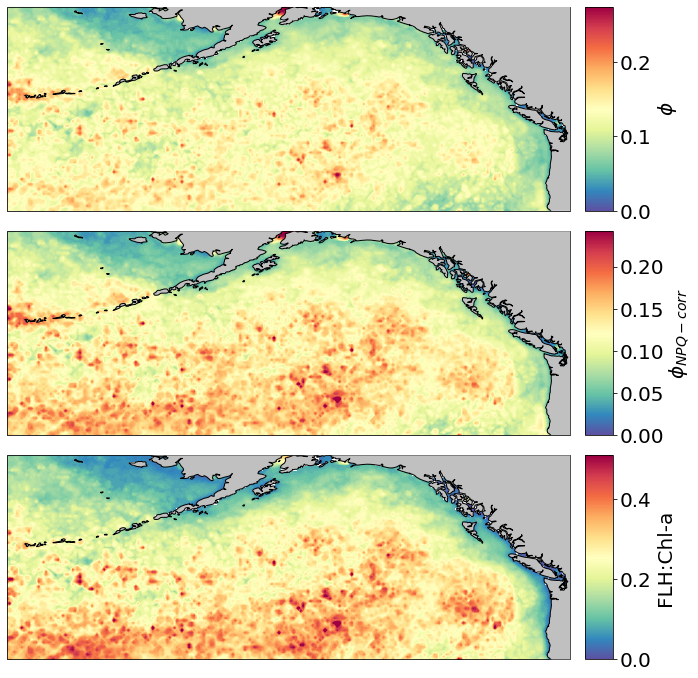

In [9]:
etopo_unstack = pd.Series(pd.concat([etopo]*3).values[:,0], index=CHL_sat_interp.stack().stack().index).unstack().unstack()

# Algorithm from Beherenfield et al. (2009)
alpha = 0.0147*(CHL_sat_interp**-0.316)
phi = (FLH_sat_interp/(CHL_sat_interp*alpha*100))
phi_cor = (FLH_sat_interp/(CHL_sat_interp*alpha*100))*(iPAR_sat_interp/np.nanmean(iPAR_sat_interp))
#------------------------------------------------------------------------------
#### Plot Phi & nFLH:Chl-a
fig = plt.figure(figsize=(24,12))
cmap='Spectral_r'
ax = fig.add_subplot(311, projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
s1 = ax.pcolormesh(phi[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().columns.values,
                   phi[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().index.values,
                   phi[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().values,
                   cmap=cmap,
                   vmin=0,vmax=phi[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().max().max()*0.75,
                   transform=ccrs.PlateCarree())
ax.contourf(phi[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().columns.values,
            phi[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().index.values,
            phi[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().values,
            levels=100,
            cmap=cmap,
            vmin=0,vmax=phi[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().max().max()*0.75,
            transform=ccrs.PlateCarree())
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.2, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cb1 = plt.colorbar(s1, cax=ax_cb)
cb1.ax.tick_params(labelsize=20)
cb1.set_label('$\phi$', fontsize=20)
#------------------------------------------------------------------------------
ax2 = fig.add_subplot(312, projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
ax2.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
s2 = ax2.pcolormesh(phi_cor[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().columns.values,
                    phi_cor[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().index.values,
                    phi_cor[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().values,
                    cmap=cmap,
                    vmin=0,vmax=phi_cor[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().max().max()*0.75,
                    transform=ccrs.PlateCarree())
ax2.contourf(phi_cor.stack().stack().groupby(['latbins','lonbins']).mean().unstack().columns.values,
            phi_cor.stack().stack().groupby(['latbins','lonbins']).mean().unstack().index.values,
            phi_cor.stack().stack().groupby(['latbins','lonbins']).mean().unstack().values,
            levels=100,
            cmap=cmap,
            vmin=0,vmax=phi_cor[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().max().max()*0.75,
            transform=ccrs.PlateCarree())
divider = make_axes_locatable(ax2)
ax_cb = divider.new_horizontal(size="5%", pad=0.2, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cb1 = plt.colorbar(s2, cax=ax_cb)
cb1.ax.tick_params(labelsize=20)
cb1.set_label('$\phi_{NPQ-corr}$', fontsize=20)
#------------------------------------------------------------------------------
ax3 = fig.add_subplot(313, projection=ccrs.PlateCarree())
ax3.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
ax3.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
s3 = ax3.pcolormesh(FLH_sat_interp.div(CHL_sat_interp)[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().columns.values,
               FLH_sat_interp.div(CHL_sat_interp)[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().index.values,
               FLH_sat_interp.div(CHL_sat_interp)[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().values,
               cmap=cmap,
               vmin=0,vmax=FLH_sat_interp.div(CHL_sat_interp)[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().max().max()*0.75,
               transform=ccrs.PlateCarree())
ax3.contourf(FLH_sat_interp.div(CHL_sat_interp)[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().columns.values,
               FLH_sat_interp.div(CHL_sat_interp)[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().index.values,
               FLH_sat_interp.div(CHL_sat_interp)[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().values,
               levels=100,
               cmap=cmap,
               vmin=0,vmax=FLH_sat_interp.div(CHL_sat_interp)[etopo_unstack<0].stack().stack().groupby(['latbins','lonbins']).mean().unstack().max().max()*0.75,
               transform=ccrs.PlateCarree())
divider = make_axes_locatable(ax3)
ax_cb = divider.new_horizontal(size="5%", pad=0.2, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cb1 = plt.colorbar(s3, cax=ax_cb)
cb1.ax.tick_params(labelsize=20)
cb1.set_label('FLH:Chl-a', fontsize=20)
#------------------------------------------------------------------------------

fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.1)

## Process Data for Training/Validation

In [10]:
# stack variables dimensionally into 3d
# removed PCA - PCs were used as inputs to models early in development

# should be: time x space x variable
seq = [DMS_interp.values[...,np.newaxis],
        SAL_interp.values[...,np.newaxis]]
seq_names = ['DMS','SAL'] # IMP: assign these names for later indexing
OG_PCA_var = np.concatenate(seq, axis=2)
seq_names_OG = seq_names

In [11]:
seq = [SST_sat_interp.values[...,np.newaxis],
       CHL_sat_interp.values[...,np.newaxis],
       PAR_sat_interp.values[...,np.newaxis],
       PIC_sat_interp.values[...,np.newaxis],
       Kd_sat_interp.values[...,np.newaxis],
       SSHA_sat_interp.values[...,np.newaxis],
       # SSH_sat_interp.values[...,np.newaxis],
       WSPD_sat_interp.values[...,np.newaxis],
       NPP_sat_interp.values[...,np.newaxis],
       # CHL_sat_interp.values[...,np.newaxis]/POC_sat_interp.values[...,np.newaxis],
       FLH_sat_interp.values[...,np.newaxis]/CHL_sat_interp.values[...,np.newaxis],
       # (FLH_sat_interp*(iPAR_sat_interp/(1590/1e6))).values[...,np.newaxis]/CHL_sat_interp.values[...,np.newaxis], # NPQ-corrected, see Behrenfield et al. 2009
       # phi_cor.values[...,np.newaxis],
       CDOM_sat_interp.values[...,np.newaxis],
       MLD_interp.values[...,np.newaxis],
       SAL_argo_interp.values[...,np.newaxis],
       # SSN.values[...,np.newaxis],
       SSN_woa_interp.values[...,np.newaxis],
       # SSP_woa_interp.values[...,np.newaxis],
       NCP.values[...,np.newaxis]]
seq_names = ['SST','Chlorophyll a','PAR','Calcite (PIC)','Kd (490 nm)','SSHA', 'Wind Speed','NPP', 'nFLH:Chl-a',r'a$_{cdm}$(443)','MLD','Salinity','SSN','NCP'] # IMP: assign these names for later indexing
sat_PCA_var = np.concatenate(seq, axis=2)
seq_names_sat = seq_names

In [12]:
# reshape satelite data back to column vectors to input into models
model_input2=np.empty([])
i=0
# input_ = sat_data_rec
input_ = sat_PCA_var
for var in range(input_.shape[2]):
    data_reshape = pd.DataFrame(input_[:,:,var],
                                index=CHL_sat.index,
                                columns=CHL_sat.columns).stack().stack()
    # data_reshape.rename(seq_names[var])
    if i == 0:
        model_input2 = data_reshape
    else:
        model_input2 = pd.concat([model_input2,data_reshape],axis=1)
    i+=1

# Reshape DMS, Salinity and SST (cruise measurments) as column vectors:
model_input1 = pd.concat([DMS.stack().stack().reindex_like(model_input2),SAL.stack().stack().reindex_like(model_input2)], axis=1)

# Reassign variable names to dataframe columns:
model_input1.columns=seq_names_OG[:]
model_input2.columns=seq_names_sat[:]

# Create dataframe for bathymetry data (extracted in processing script)
bathy = pd.DataFrame(pd.concat([etopo]*3).values, index=model_input2.index)
bathy[bathy>0] = np.nan # filter out land values
bathy.columns = ['Bathymetry']

y = model_input1.iloc[:,0] # DMS
y[y == 0] = np.nan # set neg. values to nan

# Set-up dataframe with predictors to be filtered:
X_full = pd.concat([y, model_input1.iloc[:,1:], bathy, model_input2], axis=1, sort=False) # rest of variables

# Filter out negative SSN values
X_full.loc[:,'SSN'][X_full.loc[:,'SSN']<0] = 0

# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Drop bathymetry data:
X = X_full.drop('Bathymetry', axis=1)
# X = X_full
# Drop nans and restrict to satellite data:
X_full = X_full.iloc[:,2:].dropna()
X_full = X_full.iloc[:,1:]
# restrict indices to match measured DMS values:
X = X.drop('SAL', axis=1).dropna()
# drop sal for now to test full forecast:
X = X.iloc[:,1:]
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Average predictors to regional mean values
X_full_reg_mean = X_full.groupby(['lonbins','latbins']).mean()
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

# Drop nans from DMS values
y = y.dropna()
# Apply IHS transformation to DMS data
y = np.arcsinh(y)

# split the 80:20 of the data for training:testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('Proportion of training data = %.2f' % round(X_train.shape[0]/X.shape[0],2))
print('Proportion of testing data = %.2f' % round(X_test.shape[0]/X.shape[0],2))
# print('Proportion of validation data = %.2f' % round(X_vali.shape[0]/X.shape[0],2))

#-----------------------------------------------------------------------------
# Remove variables but save for use in running literature models

NPP_test = X_test.loc[:,['NPP']]
PIC_test = X_test.loc[:,['Calcite (PIC)']]
Chl_test = X_test.loc[:,['Chlorophyll a']]
Kd_test = X_test.loc[:,['Kd (490 nm)']]

NPP_full = X_full.loc[:,['NPP']]
PIC_full = X_full.loc[:,['Calcite (PIC)']]
Chl_full = X_full.loc[:,['Chlorophyll a']]
Kd_full = X_full.loc[:,['Kd (490 nm)']]

# Model Biological Configuration:
# NCP w/o Kd
X_full = X_full.drop(['NPP','Calcite (PIC)','Chlorophyll a','Kd (490 nm)'], axis=1)
X = X.drop(['NPP','Calcite (PIC)','Chlorophyll a','Kd (490 nm)'], axis=1)
X_train = X_train.drop(['NPP','Calcite (PIC)','Chlorophyll a','Kd (490 nm)'], axis=1)
X_test = X_test.drop(['NPP','Calcite (PIC)','Chlorophyll a','Kd (490 nm)'], axis=1)
X_full_reg_mean = X_full_reg_mean.drop(['NPP','Calcite (PIC)','Chlorophyll a','Kd (490 nm)'], axis=1)

# These following lines were run systemattically during sensitivity testing to determine
# the optimal biological predictor

# NCP
# X_full = X_full.drop(['NPP','Calcite (PIC)','Chlorophyll a'], axis=1)
# X = X.drop(['NPP','Calcite (PIC)','Chlorophyll a'], axis=1)
# X_train = X_train.drop(['NPP','Calcite (PIC)','Chlorophyll a'], axis=1)
# X_test = X_test.drop(['NPP','Calcite (PIC)','Chlorophyll a'], axis=1)
# X_full_reg_mean = X_full_reg_mean.drop(['NPP','Calcite (PIC)','Chlorophyll a'], axis=1)

# Chlorophyll
# X_full = X_full.drop(['NPP','NCP','Calcite (PIC)'], axis=1)
# X = X.drop(['NPP','NCP','Calcite (PIC)'], axis=1)
# X_train = X_train.drop(['NPP','NCP','Calcite (PIC)'], axis=1)
# X_test = X_test.drop(['NPP','NCP','Calcite (PIC)'], axis=1)
# X_full_reg_mean = X_full_reg_mean.drop(['NPP','NCP','Calcite (PIC)'], axis=1)

# Calcite (PIC)
# X_full = X_full.drop(['NCP','NPP', 'Chlorophyll a'], axis=1)
# X = X.drop(['NCP','NPP', 'Chlorophyll a'], axis=1)
# X_train = X_train.drop(['NPP','NCP','Chlorophyll a'], axis=1)
# X_test = X_test.drop(['NPP','NCP','Chlorophyll a'], axis=1)
# X_full_reg_mean = X_full_reg_mean.drop(['NPP','NCP','Chlorophyll a'], axis=1)

# NPP
# X_full = X_full.drop(['NCP','Calcite (PIC)','Chlorophyll a'], axis=1)
# X = X.drop(['NCP','Calcite (PIC)','Chlorophyll a'], axis=1)
# X_train = X_train.drop(['NCP','Calcite (PIC)','Chlorophyll a'], axis=1)
# X_test = X_test.drop(['NCP','Calcite (PIC)','Chlorophyll a'], axis=1)
# X_full_reg_mean = X_full_reg_mean.drop(['NCP','Calcite (PIC)','Chlorophyll a'], axis=1)

#-----------------------------------------------------------------------------

# standardize the data - has minimal effect on RFR performance, but done for consistency between algorithms
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

Proportion of training data = 0.80
Proportion of testing data = 0.20


## Random Forest Regression (RFR)

In [13]:
#-----------------------------------------------------------------------------
#### Define model
start = timeit.default_timer() # start the clock

nfeatures = np.min(X_train.shape)
# nfeatures = 7

RFR_model = RandomForestRegressor(n_estimators=1000,
                                  max_features=nfeatures,
                                  min_samples_leaf=1, # 1 is default
                                  max_depth=25, # None is default
                                  # ccp_alpha=0, # 0 is default
                                  n_jobs=-1, # use all core processors in computer (i.e. speed up computation)
                                  random_state=0,# this just seeds the randomization of the ensemble models each time
                                  bootstrap=True,
                                  oob_score=False,
                                  verbose=False) 

# fit the model to the training data
RFR_model.fit(X_train, y_train)
# RFR_model.fit(X_train.groupby(['lonbins','latbins']).mean(), y_train.groupby(['lonbins','latbins']).mean())
#-----------------------------------------------------------------------------
#### Validate the model
y_pred = RFR_model.predict(X_test)
# y_pred = RFR_model.predict(X_test.groupby(['lonbins','latbins']).mean())

# score = RFR_model.score(X,y)
n_features = RFR_model.n_features_
importances = RFR_model.feature_importances_

# Calculate the absolute errors
errors = abs(y_pred - y_test)
print('Average absolute error:', round(np.mean(errors), 2))

# Calculate mean absolute percentage error (MAPE)
mape = (errors / y_test) * 100
print('Average absolute percent error:', round(np.mean(mape), 2))

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
end = timeit.default_timer() # stop the clock

RFR_model_R2 = RFR_model.score(X_test,y_test)
y_pred_subset = RFR_model.predict(scaler.transform(X)) 
#-----------------------------------------------------------------------------
#### Evaluate the model
print()
print('~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~')
print('             RFR Model Results         ')
print('~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~')
RFR_execution_time = end-start
print('\nExecution time:')
print(str(round(RFR_execution_time,5)),'seconds') 
print(str(round((RFR_execution_time)/60,5)),'mins')
print(str(round((RFR_execution_time)/3600,5)),'hrs')
print('Number of trees in ensemble:',str(RFR_model.n_estimators))
print('Mean Absolute Error (MAE):', round(metrics.mean_absolute_error(y_test, y_pred),4))
print('Mean Squared Error (MSE):', round(metrics.mean_squared_error(y_test, y_pred),4))
# print('Mean Prediction Accuracy (100-MAPE):', round(accuracy, 2), '%')
print('Training Root Mean Squared Error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_train, RFR_model.predict(X_train))),4))
print("Training accuracy (R^2): %0.3f" % RFR_model.score(X_train, y_train))
print('Testing Root Mean Squared Error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),4))
print("Testing accuracy (R^2): %0.3f" % RFR_model.score(X_test, y_test))
# print("Validation accuracy (R^2): %0.3f" % RFR_model.score(X_vali, y_vali))
print('- - - - - - - - - - - -')
print('Full model R^2: %0.3f' % RFR_model_R2)
print('Full model RMSE: %0.3f' % np.sqrt(metrics.mean_squared_error(y_test, RFR_model.predict(X_test))))
# print('Variable importance: ' + str(importances))
print('~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~')
print()

#------------------------------------------------------------------------------

# Quick plot to assess fit:
# plt.figure(figsize=(24,24))
# plt.plot(y.values,'k-')
# plt.plot(y_pred_subset,'g-')

Average absolute error: 0.38
Average absolute percent error: 25.84

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
             RFR Model Results         
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

Execution time:
5.82085 seconds
0.09701 mins
0.00162 hrs
Number of trees in ensemble: 1000
Mean Absolute Error (MAE): 0.3833
Mean Squared Error (MSE): 0.27
Training Root Mean Squared Error (RMSE): 0.1988
Training accuracy (R^2): 0.943
Testing Root Mean Squared Error (RMSE): 0.5196
Testing accuracy (R^2): 0.615
- - - - - - - - - - - -
Full model R^2: 0.615
Full model RMSE: 0.520
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~



In [14]:
#### Now predict values 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# extract the coords from MultiIndex for plotting
date_ind = np.asarray([x[0] for x in y.index])
lon_plt = np.asarray([x[1] for x in y.index])
lat_plt = np.asarray([x[2] for x in y.index])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# RFR_model prediction of DMS values
y_pred = RFR_model.predict(scaler.transform(X_full))
y_pred_regional = RFR_model.predict(scaler.transform(X_full_reg_mean)) 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Reshape data to plotting grids by time point

# y_pred values:
# need to shape as dataframe first
y_pred_stack = pd.Series(y_pred,index=[X_full.index.get_level_values('datetime'),
                                        X_full.index.get_level_values('lonbins'),
                                        X_full.index.get_level_values('latbins')], name='DMS')
y_pred_stack.index.set_names(('DateTime', 'Lon', 'Lat'), inplace=True)

y_pred_unstack = y_pred_stack.unstack('Lon')
y_preds = []
for ind in np.unique(y_pred_unstack.index.get_level_values('DateTime')):
    y_preds.append(y_pred_unstack.loc[ind])


# y values:
y.index.set_names(('DateTime','Lon','Lat'), inplace=True)
y_unstack = y.unstack('Lon')
y_unstack = y_unstack.reindex_like(y_pred_unstack)

ys = []
for ind in np.unique(y_unstack.index.get_level_values('DateTime')):
    ys.append(y_unstack.loc[ind])
#-----------------------------------------------------------------------------
# Calculate mean regional DMS across timeseries
# Predicted:
y_pred_full_unstack = y_pred_unstack.unstack('Lat').mean(axis=0)
y_pred_mean = y_pred_full_unstack.unstack('Lon')
# measured:
y_meas_full_unstack = y_unstack.unstack('Lat').mean(axis=0)
y_meas_mean = y_meas_full_unstack.unstack('Lon')
#-----------------------------------------------------------------------------
print()
print('Modelled R2:')
print(RFR_model_R2)
print()
print('Mean [DMS]')
print(str(round(np.mean(np.sinh(y_pred_stack).values),2))+' +/- '+str(round(np.std(np.sinh(y_pred_stack).values),2)))


Modelled R2:
0.6154606574179913

Mean [DMS]
3.98 +/- 2.13


## Artificial Neural Network (ANN) 

In [15]:
start = timeit.default_timer() # start the clock
#-----------------------------------------------------------------------------
def ANN_ensemble_builder(X_train, y_train, num_models=10):
    # Define number of models in ensemble
    ensemble = num_models
    
    # Define hyperparameters:
        # These should be chosen by cross-validation (see cell above)
    num_hidden_neurons = 30
    num_hidden_layers = 2
    max_iter = int(1e9) # max number of iterations (epochs) to run
    alpha = 0.003 # Regularization parameter - penalize to reduce overfitting
    # alpha = 0.0001 # Regularization parameter - penalize to reduce overfitting
    validation_fraction = 0.2 # Percentage of data to leave for internal validation
    batch_size = 32 # size of 'mini batches' used by stochastic optimizer
    solver = 'lbfgs' # use quasi-Newton optimizer optimization method
    # solver = 'adam'
    activation = 'logistic' # activation function to use for the hidden layer
    learning_rate_init = 0.001 # learning rate - equals step size for optimization method
    tol = 1e-6 # threshold for loss function to improve by before training is stopped
    max_fun = int(1.5e5)
    
    # Define list to store models in (the ensemble):
    ANN_ensemble = []
    
    # Iterate to create ensemble:
    for member in tqdm(range(ensemble)):
        # Define MLP model:
        MLP_model = MLPRegressor(hidden_layer_sizes=(num_hidden_neurons,num_hidden_layers), 
                             verbose=False,
                             max_iter=max_iter,
                             alpha=alpha,
                             early_stopping = True,
                             validation_fraction = validation_fraction,
                             batch_size = batch_size,
                             solver = solver,
                             activation = activation,
                             learning_rate_init = learning_rate_init,
                             tol=tol,
                             # random_state=42, # used in selecting design framework; comment out for running full ensemble
                             max_fun=max_fun)
        # Fit the model:
        MLP_model.fit(X_train,y_train)
        # Store model for use in ensemble later
        ANN_ensemble.append(MLP_model)
        
        #print('Model #'+str(member+1)+' of '+str(ensemble)+' models fitted')
    return num_models, ANN_ensemble
#-----------------------------------------------------------------------------
print('\nEnsmeble function built!')
# Build the ensemble:
print('Now buiding the ensemble...')
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Set the size of the ensemble - make sure this matches RFR!
num_models = 1000
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

num_models, ANN_ensemble = ANN_ensemble_builder( X_train, y_train, num_models=num_models)

#-----------------------------------------------------------------------------
# Predict from training and test dataset from ensemble models - use this to assess fit in plots later on:
y_train_pred = [ANN_ensemble[model].predict(X_train) for model in range(len(ANN_ensemble))]
y_test_pred = [ANN_ensemble[model].predict(X_test) for model in range(len(ANN_ensemble))]

# Average through ensemble predictions to get final modelled values:
ANN_y_train_predict = np.mean([ANN_ensemble[model].predict(X_train) for model in range(len(ANN_ensemble))], axis=0)
ANN_y_test_predict = np.mean([ANN_ensemble[model].predict(X_test) for model in range(len(ANN_ensemble))], axis=0)
ANN_y_predict = np.mean([ANN_ensemble[model].predict(scaler.transform(X_full)) for model in range(len(ANN_ensemble))], axis=0)
#-----------------------------------------------------------------------------
# Calculate correlation coefficients
ANN_corrcoefs = np.empty([len(y_test_pred)])
for i, model in enumerate(y_test_pred):
    rs = pearsonr(y_test_pred[i], y_test)
    # rs = pearsonr(np.sinh(single_tree.predict(scaler.transform(X))), y)
    ANN_corrcoefs[i] = rs[0]
#-----------------------------------------------------------------------------
# Reshape predictions
ANN_y_pred = pd.DataFrame(ANN_y_predict, index=X_full.index)
# ANN_y_pred.columns = ['DMS']

ANN_y_pred_unstack = ANN_y_pred.unstack('lonbins')
ANN_y_pred_unstack.columns = ANN_y_pred_unstack.columns.droplevel(0)
ANN_y_preds = []
for ind in np.unique(ANN_y_pred_unstack.index.get_level_values('datetime')):
    ANN_y_preds.append(ANN_y_pred_unstack.loc[ind])

ANN_y_pred_full_unstack = ANN_y_pred_unstack.unstack('latbins').mean(axis=0)
ANN_y_pred_mean = ANN_y_pred_full_unstack.unstack('lonbins')
#-----------------------------------------------------------------------------
end = timeit.default_timer() # stop the clock
ANN_execution_time = end-start
#-----------------------------------------------------------------------------
#### Evaluate the model
print()
print('~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~')
print('             ANN Model Results         ')
print('~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~')
print('\nExecution time:')
print(str(round(ANN_execution_time,5)),'seconds') 
print(str(round((ANN_execution_time)/60,5)),'mins')
print(str(round((ANN_execution_time)/3600,5)),'hrs')
print('Number of models in ensemble:',str(num_models))
print('Mean Absolute Error (MAE):', round(metrics.mean_absolute_error(y_test, ANN_y_test_predict),4))
print('Mean Squared Error (MSE):', round(metrics.mean_squared_error(y_test, ANN_y_test_predict),4))
print('Root Mean Squared Error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test, ANN_y_test_predict)),4))
# print('Mean Prediction Accuracy (100-MAPE):', round(accuracy, 2), '%')
ANN_model_R2 = r2_score(y_test,ANN_y_test_predict)
print('Training Root Mean Squared Error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_train, ANN_y_train_predict)),4))
print("Training accuracy (R^2): %0.3f" % r2_score(y_train,ANN_y_train_predict))
print('Testing Root Mean Squared Error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test, ANN_y_test_predict)),4))
print("Testing accuracy (R^2): %0.3f" % ANN_model_R2)
print('~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~')
print()

#------------------------------------------------------------------------------
print('Mean [DMS]')
print(str(round(np.mean(np.sinh(ANN_y_pred).values),2))+' +/- '+str(round(np.std(np.sinh(ANN_y_pred).values),2)))

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]


Ensmeble function built!
Now buiding the ensemble...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [5:56:27<00:00, 21.39s/it]



~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
             ANN Model Results         
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

Execution time:
21457.65389 seconds
357.62756 mins
5.96046 hrs
Number of models in ensemble: 1000
Mean Absolute Error (MAE): 0.3707
Mean Squared Error (MSE): 0.2736
Root Mean Squared Error (RMSE): 0.5231
Training Root Mean Squared Error (RMSE): 0.2736
Training accuracy (R^2): 0.892
Testing Root Mean Squared Error (RMSE): 0.5231
Testing accuracy (R^2): 0.610
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

Mean [DMS]
4.6 +/- 2.94


## Back-calculate sea-air fluxes

In [16]:
#### RFR

#~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# See Saltzman et al. (1993) and Simo & Dachs (2002):
#~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
#                          ===================
#                               Modelled
#                          ===================
#-----------------------------------------------------------------------------
t = X_full.loc[:,['SST']].values # SST (oC)
u = X_full.loc[:,['Wind Speed']].values # Wind Speed (m s^-1)
# eta_sq = 4*(u**2)/np.pi
Xi = 2 # Assuming a Rayleigh Distribution, see Livingstone & Imboden (1993)
s = (1+(1/Xi))
eta_sq = (u/scipy.special.gamma(s))**2
#-----------------------------------------------------------------------------
# Schmidt number (cm^2 sec^-1):
Sc = 2674-(147.12*t)+(3.72*t**2)-(0.038*t**3)
# Gas transfer velocity (cm^3 hr^-1) for DMS:
# k_dms = (0.27*u**2)*(Sc/660)**(-0.5) # Wang et al. (2020) parameterization
k_dms = (5.88*eta_sq*scipy.special.gamma(1+(2/Xi))\
         +1.49*np.sqrt(eta_sq)*scipy.special.gamma(s))*(Sc**-0.5) # See Simo & Dachs (2007)
#-----------------------------------------------------------------------------
# Flux rates (umol m^-2 d^-1):
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

# Note - back-transformed here: 
flux_pred = k_dms*(np.sinh(y_pred).reshape(-1,1))*0.24 # 0.24 converts hr^-1 to d^-1 (& cm to m)

# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
flux_pred = pd.DataFrame(flux_pred,index=X_full.loc[:,['SST']].index)
flux_pred.columns=['DMS flux']
flux_pred_unstack = flux_pred.unstack('lonbins')
flux_pred_unstack.columns = flux_pred_unstack.columns.droplevel(0)
flux_preds = []
for ind in np.unique(flux_pred_unstack.index.get_level_values('datetime')):
    flux_preds.append(flux_pred_unstack.loc[ind])
#-----------------------------------------------------------------------------
#                          ===================
#                                Actual
#                          ===================
#-----------------------------------------------------------------------------
t = X.loc[:,['SST']].values # SST (oC)
u = X.loc[:,['Wind Speed']].values # Wind Speed (m s^-1)
# eta_sq = 4*(u**2)/np.pi
Xi = 2 # Assuming a Rayleigh Distribution, see Livingstone & Imboden (1993)
s = (1+(1/Xi))
eta_sq = (u/scipy.special.gamma(s))**2
#-----------------------------------------------------------------------------
# Schmidt number (cm^2 sec^-1):
Sc = 2674-(147.12*t)+(3.72*t**2)-(0.038*t**3)
# Gas transfer velocity (cm^3 hr^-1) for DMS:
# k_dms = (0.27*u**2)*(Sc/660)**(-0.5) # Wang et al. (2020) parameterization
k_dms = (5.88*eta_sq*scipy.special.gamma(1+(2/Xi))\
         +1.49*np.sqrt(eta_sq)*scipy.special.gamma(s))*(Sc**-0.5) # See Simo & Dachs (2007)
#-----------------------------------------------------------------------------
# Flux rates (umol m^-2 d^-1):
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

# Note - back-transformed here: 
flux_meas = k_dms*(np.sinh(y).values.reshape(-1,1))*0.24 # converts to d^-1 (& cm to m)

# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
flux_meas = pd.DataFrame(flux_meas,index=X.loc[:,['SST']].index)
flux_meas.columns=['DMS flux']
flux_meas_unstack = flux_meas.unstack('lonbins')
flux_meas_unstack.columns = flux_meas_unstack.columns.droplevel(0)
flux_meas_unstack = flux_meas_unstack.reindex_like(flux_pred_unstack)
fluxes = []
for ind in np.unique(flux_meas_unstack.index.get_level_values('datetime')):
    fluxes.append(flux_meas_unstack.loc[ind])
#-----------------------------------------------------------------------------
#                          ===================
#                            Regional Fluxes
#                          ===================
#-----------------------------------------------------------------------------
# average/unstack wind field values across timeseries
U_mean = U_sat_interp.mean(axis=0).unstack('lonbins')
V_mean = V_sat_interp.mean(axis=0).unstack('lonbins')
WSPD_mean = WSPD_sat_interp.mean(axis=0).unstack('lonbins')
#-----------------------------------------------------------------------------
# convert wind vectors to lists
WSPD_unstack = WSPD_sat_interp[:-1].stack('latbins')
WSPDs = []
for ind in np.unique(WSPD_unstack.index.get_level_values('datetime')):
    WSPDs.append(WSPD_unstack.loc[ind])

U_unstack = U_sat_interp[:-1].stack('latbins')
Us = []
for ind in np.unique(U_unstack.index.get_level_values('datetime')):
    Us.append(U_unstack.loc[ind])

V_unstack = V_sat_interp[:-1].stack('latbins')
Vs = []
for ind in np.unique(V_unstack.index.get_level_values('datetime')):
    Vs.append(V_unstack.loc[ind])
#-----------------------------------------------------------------------------
# For modelled flux rates...
flux_pred_unstack = flux_pred.unstack('lonbins').unstack('latbins')
# ...Average across time (plot spatially)
flux_pred_unstack_mean = flux_pred_unstack.mean(axis=0).droplevel(0)
flux_pred_mean = flux_pred_unstack_mean.unstack('lonbins')
#-----------------------------------------------------------------------------
# For actual flux rates...
flux_meas_unstack = flux_meas.unstack('lonbins').unstack('latbins').reindex_like(flux_pred_unstack)
# ...Average across time (plot spatially)
flux_meas_unstack_mean = flux_meas_unstack.mean(axis=0).droplevel(0)
flux_meas_mean = flux_meas_unstack_mean.unstack('lonbins')
#-----------------------------------------------------------------------------
# Define constants:
# See this post: https://stackoverflow.com/questions/47894513/checking-if-a-geocoordinate-point-is-land-or-ocean-with-cartopy
land_shp_fname = shpreader.natural_earth(resolution='50m',
                                       category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

# Function for determining whether a grid cell is covered by land:
def is_land(x, y):
    return land.contains(sgeom.Point(x, y))

# Check whether grid cell is on land or at sea:
check=np.empty([flux_pred_mean.index.size,flux_pred_mean.columns.size])
for i in range(len(flux_pred_mean.index.values)):
    for j in range(len(flux_pred_mean.columns.values)):
        check[i,j] = is_land(flux_pred_mean.columns.values[j],flux_pred_mean.index.values[i])

# percentage of study region area attributted to ocean:
frac_ocean = 1-check[check>0].size/check.size 
#~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
# Constants:
A = ((max_lat-min_lat)*111*1000)*((max_lon-min_lon)*111*1000) # total regional area
A_ocean = A*frac_ocean # fraction of total area covered by ocean
S_mol_mass = 32.06 # molar mass of sulfur
#-----------------------------------------------------------------------------

# Mean regional modelled flux (convert to Tg for summertime (~92 days))
flux_pred_reg_mean = (flux_pred_unstack.mean().mean()*S_mol_mass*A_ocean*92)/(1e6*1e12)

# Mean regional measured flux (convert to Tg for summertime (~92 days))
flux_meas_reg_mean = (flux_meas_unstack.mean().mean()*S_mol_mass*A_ocean*92)/(1e6*1e12)

# Regional fluxes per month (convert to Tg for summertime (~92 days))
flux_pred_regs = []
for ind,df in enumerate(flux_preds):
    flux_pred_regs.append((flux_preds[ind].mean().mean()*S_mol_mass*A_ocean*92)/(1e6*1e12))
flux_meas_regs = []
for ind,df in enumerate(fluxes):
    flux_meas_regs.append((fluxes[ind].mean().mean()*S_mol_mass*A_ocean*92)/(1e6*1e12))
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('Mean DMS flux')
print(str(round(np.mean(flux_pred.values),2))+' +/- '+str(round(np.std(flux_pred.values),2)))

Mean DMS flux
7.74 +/- 4.45


In [17]:
#### ANN

#~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# See Saltzman et al. (1993) and Simo & Dachs (2002):
#~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
#                          ===================
#                               Modelled
#                          ===================
#-----------------------------------------------------------------------------
t = X_full.loc[:,['SST']].values # SST (oC)
u = X_full.loc[:,['Wind Speed']].values # Wind Speed (m s^-1)
# eta_sq = 4*(u**2)/np.pi
Xi = 2 # Assuming a Rayleigh Distribution, see Livingstone & Imboden (1993)
s = (1+(1/Xi))
eta_sq = (u/scipy.special.gamma(s))**2
#-----------------------------------------------------------------------------
# Schmidt number (cm^2 sec^-1):
Sc = 2674-(147.12*t)+(3.72*t**2)-(0.038*t**3)
# Gas transfer velocity (cm^3 hr^-1) for DMS:
# k_dms = (0.27*u**2)*(Sc/660)**(-0.5) # Wang et al. (2020) parameterization
k_dms = (5.88*eta_sq*scipy.special.gamma(1+(2/Xi))\
         +1.49*np.sqrt(eta_sq)*scipy.special.gamma(s))*(Sc**-0.5) # See Simo & Dachs (2007)
#-----------------------------------------------------------------------------
# Flux rates (umol m^-2 d^-1):
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

# Note - back-transformed here: 
ANN_flux_pred = k_dms*(np.sinh(ANN_y_pred))*0.24 # 0.24 converts hr^-1 to d^-1 (& cm to m)

# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
ANN_flux_pred = pd.DataFrame(ANN_flux_pred,index=X_full.loc[:,['SST']].index)
ANN_flux_pred.columns=['DMS flux']
ANN_flux_pred_unstack = ANN_flux_pred.unstack('lonbins')
ANN_flux_pred_unstack.columns = ANN_flux_pred_unstack.columns.droplevel(0)
ANN_flux_preds = []
for ind in np.unique(ANN_flux_pred_unstack.index.get_level_values('datetime')):
    ANN_flux_preds.append(ANN_flux_pred_unstack.loc[ind])
#-----------------------------------------------------------------------------
#                          ===================
#                                Actual
#                          ===================
#-----------------------------------------------------------------------------
t = X.loc[:,['SST']].values # SST (oC)
u = X.loc[:,['Wind Speed']].values # Wind Speed (m s^-1)
# eta_sq = 4*(u**2)/np.pi
Xi = 2 # Assuming a Rayleigh Distribution, see Livingstone & Imboden (1993)
s = (1+(1/Xi))
eta_sq = (u/scipy.special.gamma(s))**2
#-----------------------------------------------------------------------------
# Schmidt number (cm^2 sec^-1):
Sc = 2674-(147.12*t)+(3.72*t**2)-(0.038*t**3)
# Gas transfer velocity (cm^3 hr^-1) for DMS:
# k_dms = (0.27*u**2)*(Sc/660)**(-0.5) # Wang et al. (2020) parameterization
k_dms = (5.88*eta_sq*scipy.special.gamma(1+(2/Xi))\
         +1.49*np.sqrt(eta_sq)*scipy.special.gamma(s))*(Sc**-0.5) # See Simo & Dachs (2007)
#-----------------------------------------------------------------------------
# Flux rates (umol m^-2 d^-1):
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

# Note - back-transformed here: 
flux_meas = k_dms*(np.sinh(y).values.reshape(-1,1))*0.24 # converts to d^-1 (& cm to m)

# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
flux_meas = pd.DataFrame(flux_meas,index=X.loc[:,['SST']].index)
flux_meas.columns=['DMS flux']
flux_meas_unstack = flux_meas.unstack('lonbins')
flux_meas_unstack.columns = flux_meas_unstack.columns.droplevel(0)
flux_meas_unstack = flux_meas_unstack.reindex_like(ANN_flux_pred_unstack)
fluxes = []
for ind in np.unique(flux_meas_unstack.index.get_level_values('datetime')):
    fluxes.append(flux_meas_unstack.loc[ind])
#-----------------------------------------------------------------------------
#                          ===================
#                            Regional Fluxes
#                          ===================
#-----------------------------------------------------------------------------
# average/unstack wind field values across timeseries
U_mean = U_sat_interp.mean(axis=0).unstack('lonbins')
V_mean = V_sat_interp.mean(axis=0).unstack('lonbins')
WSPD_mean = WSPD_sat_interp.mean(axis=0).unstack('lonbins')
#-----------------------------------------------------------------------------
# convert wind vectors to lists
WSPD_unstack = WSPD_sat_interp[:-1].stack('latbins')
WSPDs = []
for ind in np.unique(WSPD_unstack.index.get_level_values('datetime')):
    WSPDs.append(WSPD_unstack.loc[ind])

U_unstack = U_sat_interp[:-1].stack('latbins')
Us = []
for ind in np.unique(U_unstack.index.get_level_values('datetime')):
    Us.append(U_unstack.loc[ind])

V_unstack = V_sat_interp[:-1].stack('latbins')
Vs = []
for ind in np.unique(V_unstack.index.get_level_values('datetime')):
    Vs.append(V_unstack.loc[ind])
#-----------------------------------------------------------------------------
# For modelled flux rates...
ANN_flux_pred_unstack = ANN_flux_pred.unstack('lonbins').unstack('latbins')
# ...Average across time (plot spatially)
ANN_flux_pred_unstack_mean = ANN_flux_pred_unstack.mean(axis=0).droplevel(0)
ANN_flux_pred_mean = ANN_flux_pred_unstack_mean.unstack('lonbins')
#-----------------------------------------------------------------------------
# For actual flux rates...
flux_meas_unstack = flux_meas.unstack('lonbins').unstack('latbins').reindex_like(ANN_flux_pred_unstack)
# ...Average across time (plot spatially)
flux_meas_unstack_mean = flux_meas_unstack.mean(axis=0).droplevel(0)
flux_meas_mean = flux_meas_unstack_mean.unstack('lonbins')
#-----------------------------------------------------------------------------
# Define constants:
# See this post: https://stackoverflow.com/questions/47894513/checking-if-a-geocoordinate-point-is-land-or-ocean-with-cartopy
land_shp_fname = shpreader.natural_earth(resolution='50m',
                                       category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

# Function for determining whether a grid cell is covered by land:
def is_land(x, y):
    return land.contains(sgeom.Point(x, y))

# Check whether grid cell is on land or at sea:
check=np.empty([ANN_flux_pred_mean.index.size,ANN_flux_pred_mean.columns.size])
for i in range(len(ANN_flux_pred_mean.index.values)):
    for j in range(len(ANN_flux_pred_mean.columns.values)):
        check[i,j] = is_land(ANN_flux_pred_mean.columns.values[j],ANN_flux_pred_mean.index.values[i])

# percentage of study region area attributted to ocean:
frac_ocean = 1-check[check>0].size/check.size 
#~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
# Constants:
A = ((max_lat-min_lat)*111*1000)*((max_lon-min_lon)*111*1000) # total regional area (m3)
A_ocean = A*frac_ocean # fraction of total area covered by ocean
S_mol_mass = 32.06 # molar mass of sulfur (g/mol)
#-----------------------------------------------------------------------------

# Mean regional modelled flux (convert to Tg for summertime (~92 days))
ANN_flux_pred_reg_mean = (ANN_flux_pred_unstack.mean().mean()*S_mol_mass*A_ocean*92)/(1e6*1e12)

# Mean regional measured flux (convert to Tg for summertime (~92 days))
flux_meas_reg_mean = (flux_meas_unstack.mean().mean()*S_mol_mass*A_ocean*92)/(1e6*1e12)

# Regional fluxes per month (convert to Tg for summertime (~92 days))
ANN_flux_pred_regs = []
for ind,df in enumerate(ANN_flux_preds):
    ANN_flux_pred_regs.append((ANN_flux_preds[ind].mean().mean()*S_mol_mass*A_ocean*92)/(1e6*1e12))
flux_meas_regs = []
for ind,df in enumerate(fluxes):
    flux_meas_regs.append((fluxes[ind].mean().mean()*S_mol_mass*A_ocean*92)/(1e6*1e12))
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#### Calculate total S emitted per individual model in ensemble to generate uncertainity range:
print('ANN Fluxes:')
print(str(round(np.mean(np.mean(((ANN_flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92))),2))+'+/-'+str(round(np.std(np.std(((ANN_flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92))),2))+' TgS yr^-1')
print(str(round(np.mean(np.mean(((ANN_flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12)))),2))+'+/-'+str(round(np.std(np.std(((ANN_flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12)))),2))+' TgS')
print()
print('Mean DMS flux')
print(str(round(np.mean(ANN_flux_pred.values),2))+' +/- '+str(round(np.std(ANN_flux_pred.values),2)))

ANN Fluxes:
1.35+/-0.49 TgS yr^-1
0.34+/-0.12 TgS

Mean DMS flux
9.02 +/- 6.47


## Calculate NESAP sea-air fluxes from Lana et al. (2011)

In [18]:
#------------------------------------------------------------------------------
#### Import 1x1o SST/Wind Speed data
# Retrieve the data
SST_sat_interp1 = pd.read_csv(write_dir+'SST_sat_interp_'+str(1)+'.csv',index_col=[0], header=[0,1])
WSPD_sat_interp1 = pd.read_csv(write_dir+'WSPD_sat_interp_'+str(1)+'.csv',index_col=[0], header=[0,1])
etopo1 = pd.read_csv(write_dir+'etopo2_'+str(1)+'.csv', index_col=[0,1])

# Convert lat/lons to float values
SST_sat_interp1.columns = SST_sat_interp1.columns.set_levels(SST_sat_interp1.columns.levels[0].astype(float), level=0)
SST_sat_interp1.columns = SST_sat_interp1.columns.set_levels(SST_sat_interp1.columns.levels[1].astype(float), level=1)
WSPD_sat_interp1.columns = WSPD_sat_interp1.columns.set_levels(WSPD_sat_interp1.columns.levels[0].astype(float), level=0)
WSPD_sat_interp1.columns = WSPD_sat_interp1.columns.set_levels(WSPD_sat_interp1.columns.levels[1].astype(float), level=1)
#------------------------------------------------------------------------------
# Concatenate data and mask out land
climat_data = pd.concat([pd.DataFrame(pd.concat([etopo1]*3).values, index=WSPD_sat_interp1.stack().stack().index), # match array size - this repeats bathymetry data for 3 months
                         WSPD_sat_interp1.stack().stack(),
                         SST_sat_interp1.stack().stack()], axis=1)
climat_data.columns = ['bathy','Wind Speed','SST']

# Mask out land "data" (i.e. remove erroneous extrapolation from the interpolation step)
climat_data[climat_data['bathy']>0] = np.nan

# now drop etopo data
climat_data.drop(labels=['bathy'], axis=1, inplace=True)
#------------------------------------------------------------------------------
#### Import Lana et al. climatology data

# set up some dicts for the lat/lon values (deduced from mapping the data - see commented code at bottom of cell):
lats_dict = pd.Series(np.arange(-89,91,1), name='latbins')
lons_dict = pd.Series(np.arange(-180,180,1), name='lonbins')

# Retrive DMS climatology values, adding lats/lons to dataframes
lana_jun = pd.DataFrame(np.flipud(pd.read_csv('C:/Users/bcamc/OneDrive/Desktop/Python/Projects/py_eosc510/Final Project/dmsclimatology/DMSclim_JUN.csv', header=None)),
                        index=lats_dict, columns=lons_dict)
lana_jul = pd.DataFrame(np.flipud(pd.read_csv('C:/Users/bcamc/OneDrive/Desktop/Python/Projects/py_eosc510/Final Project/dmsclimatology/DMSclim_JUL.csv', header=None)),
                        index=lats_dict, columns=lons_dict)
lana_aug = pd.DataFrame(np.flipud(pd.read_csv('C:/Users/bcamc/OneDrive/Desktop/Python/Projects/py_eosc510/Final Project/dmsclimatology/DMSclim_AUG.csv', header=None)),
                        index=lats_dict, columns=lons_dict)

# Restrict the data to our NESAP study region
lana_jun = lana_jun.loc[min_lat:max_lat,min_lon:max_lon]
lana_jul = lana_jul.loc[min_lat:max_lat,min_lon:max_lon]
lana_aug = lana_aug.loc[min_lat:max_lat,min_lon:max_lon]

# Concatenate the arrays together (keep in nans to preserve shape)
lana_climat = pd.DataFrame(pd.concat([lana_jun.stack(dropna=False), lana_jul.stack(dropna=False), lana_aug.stack(dropna=False)], axis=0))
# Create date index
c_dates = pd.concat([pd.Series(np.tile(np.array(6),int(lana_climat.shape[0]/3))),
                     pd.Series(np.tile(np.array(7),int(lana_climat.shape[0]/3))),
                     pd.Series(np.tile(np.array(8),int(lana_climat.shape[0]/3)))],axis=0, names='datetime')
# Now do some Pandas magic...
lana_climat['datetime'] = c_dates.values # add in dates
lana_climat.set_index('datetime', append=True, inplace=True) # set dates into index
lana_climat = lana_climat.reorder_levels(['datetime','lonbins','latbins']) # match indices with SST/wind data

#------------------------------------------------------------------------------
#### Calculate fluxes
#~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# See Saltzman et al. (1993) and Simo & Dachs (2002):
#~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
#-----------------------------------------------------------------------------
t = climat_data.loc[:,['SST']].values # SST (oC)
u = climat_data.loc[:,['Wind Speed']].values # Wind Speed (m s^-1)
# eta_sq = 4*(u**2)/np.pi
Xi = 2 # Assuming a Rayleigh Distribution, see Livingstone & Imboden (1993)
s = (1+(1/Xi))
eta_sq = (u/scipy.special.gamma(s))**2
#-----------------------------------------------------------------------------
# Schmidt number (cm^2 sec^-1):
Sc = 2674-(147.12*t)+(3.72*t**2)-(0.038*t**3)
# Gas transfer velocity (cm^3 hr^-1) for DMS:
k_dms = (5.88*eta_sq*scipy.special.gamma(1+(2/Xi))\
         +1.49*np.sqrt(eta_sq)*scipy.special.gamma(s))*(Sc**-0.5) # See Simo & Dachs (2007)
#-----------------------------------------------------------------------------
# Flux rates (umol m^-2 d^-1):
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

# Note - back-transformed here: 
lana_flux_pred = k_dms*(lana_climat.values.reshape(-1,1))*0.24 # 0.24 converts hr^-1 to d^-1 (& cm to m)

# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
lana_flux_pred = pd.DataFrame(lana_flux_pred,index=climat_data.loc[:,['SST']].index)
lana_flux_pred.columns=['DMS flux']
lana_flux_pred_unstack = lana_flux_pred.unstack('lonbins')
lana_flux_pred_unstack.columns = lana_flux_pred_unstack.columns.droplevel(0)
lana_flux_preds = []
for ind in np.unique(lana_flux_pred_unstack.index.get_level_values('datetime')):
    lana_flux_preds.append(lana_flux_pred_unstack.loc[ind])

#-----------------------------------------------------------------------------
# For modelled flux rates...
lana_flux_pred_unstack = lana_flux_pred.unstack('lonbins').unstack('latbins')
# ...Average across time (plot spatially)
lana_flux_pred_unstack_mean = lana_flux_pred_unstack.mean(axis=0).droplevel(0)
lana_flux_pred_mean = lana_flux_pred_unstack_mean.unstack('lonbins')
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
#-----------------------------------------------------------------------------
# Define constants:
# See this post: https://stackoverflow.com/questions/47894513/checking-if-a-geocoordinate-point-is-land-or-ocean-with-cartopy
land_shp_fname = shpreader.natural_earth(resolution='50m',
                                       category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

# Function for determining whether a grid cell is covered by land:
def is_land(x, y):
    return land.contains(sgeom.Point(x, y))

# Check whether grid cell is on land or at sea:
check=np.empty([lana_flux_pred_mean.index.size,lana_flux_pred_mean.columns.size])
for i in range(len(lana_flux_pred_mean.index.values)):
    for j in range(len(lana_flux_pred_mean.columns.values)):
        check[i,j] = is_land(lana_flux_pred_mean.columns.values[j],lana_flux_pred_mean.index.values[i])

# percentage of study region area attributted to ocean:
frac_ocean = 1-check[check>0].size/check.size 
#~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
# Constants:
A = ((max_lat-min_lat)*111*1000)*((max_lon-min_lon)*111*1000) # total regional area
A_ocean = A*frac_ocean # fraction of total area covered by ocean
S_mol_mass = 32.06 # molar mass of sulfur
#-----------------------------------------------------------------------------

# Mean regional modelled flux (convert to Tg for summertime (~92 days))
lana_flux_pred_reg_mean = (lana_flux_pred_unstack.mean().mean()*S_mol_mass*A_ocean*92)/(1e6*1e12)

# Regional fluxes per month (convert to Tg for summertime (~92 days))
lana_flux_pred_regs = []
for ind,df in enumerate(lana_flux_preds):
    lana_flux_pred_regs.append((lana_flux_preds[ind].mean().mean()*S_mol_mass*A_ocean*92)/(1e6*1e12))
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('Mean DMS flux')
print(str(round(np.nanmean(lana_flux_pred.values),2))+' +/- '+str(round(np.nanstd(lana_flux_pred.values),2)))
#------------------------------------------------------------------------------

# #### Plot Climatology
# fig = plt.figure(figsize=(24,24))
# ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
# ax.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
# ax.set_extent([-180,180,-90,90])
# ax.pcolormesh(lana_jun.columns.values,lana_jun.index.values,lana_jun.values, transform=ccrs.PlateCarree())

Mean DMS flux
11.91 +/- 5.85


## Comparison of sea-air flux uncertainities

In [19]:
date_ind = np.asarray([x[0] for x in X_full.index]).astype(float)

print('RFR Fluxes:')
print('June: '+str(round(np.nanmean(flux_preds[0]),1))+'+/-'+str(round(np.nanstd(flux_preds[0]),1))+' umol m^-2 d^-1')
print('June: '+str(round(np.nanmean(((flux_preds[0]*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)),1))+'+/-'+str(round(np.nanstd(((flux_preds[0]*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)),1))+' Tg yr^-1')
print('July: '+str(round(np.nanmean(flux_preds[1]),1))+'+/-'+str(round(np.nanstd(flux_preds[1]),1))+' umol m^-2 d^-1')
print('July: '+str(round(np.nanmean(((flux_preds[1]*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)),1))+'+/-'+str(round(np.nanstd(((flux_preds[2]*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)),1))+' Tg yr^-1')
print('August: '+str(round(np.nanmean(flux_preds[2]),1))+'+/-'+str(round(np.nanstd(flux_preds[1]),1))+' umol m^-2 d^-1')
print('August: '+str(round(np.nanmean(((flux_preds[2]*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)),1))+'+/-'+str(round(np.nanstd(((flux_preds[2]*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)),1))+' Tg yr^-1')
print()
print('Summertime mean:')
print(str(round(np.nanmean(flux_pred_mean),1))+'+/-'+str(round(np.nanstd(flux_pred_mean),1))+' umol m^-2 d^-1')
print(str(round(np.nanmean(((flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)),1))+'+/-'+str(round(np.nanstd(((flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)),1))+' TgS yr^-1')
print(str(round(np.nanmean(((flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12))),1))+'+/-'+str(round(np.nanstd(((flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12))),1))+' TgS')
print('----------------------')

print('ANN fluxes:')
print('June: '+str(round(np.nanmean(ANN_flux_preds[0]),1))+'+/-'+str(round(np.nanstd(ANN_flux_preds[0]),1))+' umol m^-2 d^-1')
print('June: '+str(round(np.nanmean(((ANN_flux_preds[0]*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)),1))+'+/-'+str(round(np.nanstd(((ANN_flux_preds[0]*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)),1))+' Tg yr^-1')
print('July: '+str(round(np.nanmean(ANN_flux_preds[1]),1))+'+/-'+str(round(np.nanstd(ANN_flux_preds[1]),1))+' umol m^-2 d^-1')
print('July: '+str(round(np.nanmean(((ANN_flux_preds[1]*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)),1))+'+/-'+str(round(np.nanstd(((ANN_flux_preds[2]*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)),1))+' Tg yr^-1')
print('August: '+str(round(np.nanmean(ANN_flux_preds[2]),1))+'+/-'+str(round(np.nanstd(ANN_flux_preds[1]),1))+' umol m^-2 d^-1')
print('August: '+str(round(np.nanmean(((ANN_flux_preds[2]*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)),1))+'+/-'+str(round(np.nanstd(((ANN_flux_preds[2]*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)),1))+' Tg yr^-1')
print()
print('Summertime mean:')
print(str(round(np.nanmean(ANN_flux_pred_mean),1))+'+/-'+str(round(np.nanstd(ANN_flux_pred_mean),1))+' umol m^-2 d^-1')
print(str(round(np.nanmean(((ANN_flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)),1))+'+/-'+str(round(np.nanstd(((ANN_flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)),1))+' TgS yr^-1')
print(str(round(np.nanmean(((ANN_flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12))),1))+'+/-'+str(round(np.nanstd(((ANN_flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12))),1))+' TgS')
print('----------------------')

print('Combined Fluxes:')
june_flux_preds = pd.concat([flux_preds[0].stack(),ANN_flux_preds[0].stack()], axis=1).mean(axis=1).unstack()
july_flux_preds = pd.concat([flux_preds[1].stack(),ANN_flux_preds[1].stack()], axis=1).mean(axis=1).unstack()
august_flux_preds = pd.concat([flux_preds[2].stack(),ANN_flux_preds[2].stack()], axis=1).mean(axis=1).unstack()

june_flux_mean = np.nanmean(((june_flux_preds*S_mol_mass*A_ocean*92)/(1e6*1e12)))
june_flux_std = np.nanstd(((june_flux_preds*S_mol_mass*A_ocean*92)/(1e6*1e12)))
july_flux_mean = np.nanmean(((july_flux_preds*S_mol_mass*A_ocean*92)/(1e6*1e12)))
july_flux_std = np.nanstd(((july_flux_preds*S_mol_mass*A_ocean*92)/(1e6*1e12)))
august_flux_mean = np.nanmean(((august_flux_preds*S_mol_mass*A_ocean*92)/(1e6*1e12)))
august_flux_std = np.nanstd(((august_flux_preds*S_mol_mass*A_ocean*92)/(1e6*1e12)))

print('June: '+str(round(june_flux_mean-june_flux_std,1))+' - '+str(round(june_flux_mean+june_flux_std,1)))
print('July: '+str(round(july_flux_mean-july_flux_std,1))+' - '+str(round(july_flux_mean+july_flux_std,1)))
print('August: '+str(round(august_flux_mean-august_flux_std,1))+' - '+str(round(august_flux_mean+august_flux_std,1)))
print()

print('Combined Fluxes (Lana et al. 2011):')

lana_june_flux_mean = np.nanmean(((lana_flux_preds[0]*S_mol_mass*A_ocean*92)/(1e6*1e12)))
lana_june_flux_std = np.nanstd(((lana_flux_preds[0]*S_mol_mass*A_ocean*92)/(1e6*1e12)))
lana_july_flux_mean = np.nanmean(((lana_flux_preds[1]*S_mol_mass*A_ocean*92)/(1e6*1e12)))
lana_july_flux_std = np.nanstd(((lana_flux_preds[1]*S_mol_mass*A_ocean*92)/(1e6*1e12)))
lana_august_flux_mean = np.nanmean(((lana_flux_preds[2]*S_mol_mass*A_ocean*92)/(1e6*1e12)))
lana_august_flux_std = np.nanstd(((lana_flux_preds[2]*S_mol_mass*A_ocean*92)/(1e6*1e12)))

print('June: '+str(round(lana_june_flux_mean-lana_june_flux_std,1))+' - '+str(round(lana_june_flux_mean+lana_june_flux_std,1)))
print('July: '+str(round(lana_july_flux_mean-lana_july_flux_std,1))+' - '+str(round(lana_july_flux_mean+lana_july_flux_std,1)))
print('August: '+str(round(lana_august_flux_mean-lana_august_flux_std,1))+' - '+str(round(lana_august_flux_mean+lana_august_flux_std,1)))
print()

combined_flux_pred_unstack = pd.concat([flux_pred_unstack.stack().stack(),ANN_flux_pred_unstack.stack().stack()], axis=1).mean(axis=1).unstack().unstack()
print('Total summertime (this study)')
print(str(round(np.nanmean(((combined_flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12))),1))+' +/- '+str(round(np.nanstd(((combined_flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12))),1)))
print(str(round(np.nanmean(((combined_flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12)))-np.nanstd(((combined_flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12))),1))+' - '+str(round(np.nanmean(((combined_flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12)))+np.nanstd(((combined_flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12))),1)))
print('Total summertime (Lana et al. 2011)')
print(str(round(np.nanmean(((lana_flux_pred*S_mol_mass*A_ocean*92)/(1e6*1e12))),1))+' +/- '+str(round(np.nanstd(((lana_flux_pred*S_mol_mass*A_ocean*92)/(1e6*1e12))),1)))
print(str(round(np.nanmean(((lana_flux_pred*S_mol_mass*A_ocean*92)/(1e6*1e12)))-np.nanstd(((lana_flux_pred*S_mol_mass*A_ocean*92)/(1e6*1e12))),1))+' - '+str(round(np.nanmean(((lana_flux_pred*S_mol_mass*A_ocean*92)/(1e6*1e12)))+np.nanstd(((lana_flux_pred*S_mol_mass*A_ocean*92)/(1e6*1e12))),1)))
print('----------------------')

RFR Fluxes:
June: 5.9+/-3.7 umol m^-2 d^-1
June: 0.9+/-0.5 Tg yr^-1
July: 6.5+/-3.0 umol m^-2 d^-1
July: 0.9+/-0.7 Tg yr^-1
August: 10.8+/-3.0 umol m^-2 d^-1
August: 1.6+/-0.7 Tg yr^-1

Summertime mean:
7.7+/-2.4 umol m^-2 d^-1
1.1+/-0.6 TgS yr^-1
0.3+/-0.2 TgS
----------------------
ANN fluxes:
June: 5.9+/-3.9 umol m^-2 d^-1
June: 0.9+/-0.6 Tg yr^-1
July: 7.4+/-3.8 umol m^-2 d^-1
July: 1.1+/-1.1 Tg yr^-1
August: 13.7+/-3.8 umol m^-2 d^-1
August: 2.0+/-1.1 Tg yr^-1

Summertime mean:
9.0+/-3.3 umol m^-2 d^-1
1.3+/-0.9 TgS yr^-1
0.3+/-0.2 TgS
----------------------
Combined Fluxes:
June: 0.1 - 0.3
July: 0.1 - 0.4
August: 0.2 - 0.7

Combined Fluxes (Lana et al. 2011):
June: 0.2 - 0.6
July: 0.2 - 0.5
August: 0.3 - 0.8

Total summertime (this study)
0.3 +/- 0.2
0.1 - 0.5
Total summertime (Lana et al. 2011)
0.4 +/- 0.2
0.2 - 0.7
----------------------


In [20]:
print(np.nanmean(((combined_flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)))
print(np.nanstd(((combined_flux_pred_unstack*S_mol_mass*A_ocean*92)/(1e6*1e12))*(365/92)))

1.218513909034214
0.7553034580733756


In [21]:
# global ocean area in m:
global_ocean_A = 3.619e14

# fraction of total ocean accounted for in study region:
region_frac = A_ocean/global_ocean_A

# Annual global estimate range (Kettle & Andreae, 2000)
print()
print('Total flux amounts of S-DMS for study region:')
print('RFR model: '+str(round(flux_pred_reg_mean,3))+r' Tg S')
print('ANN model: '+str(round(ANN_flux_pred_reg_mean,3))+r' Tg S')
print('Herr et al. (2019): '+str(0.3)+r' Tg S')
print()
print('Corresponding yearly DMS fluxes for this region')
print('calculated from global estimates compiled in Kettle & Andreae (2000):')
print(str(round(15*region_frac*(92/365),2))+' to '+str(round(54*region_frac*(92/365),2))+r' Tg S')
print(str(round(15*region_frac,2))+' to '+str(round(54*region_frac,2))+r' Tg S/yr')
print('\nOur model:')
print('RFR = '+str(round(flux_pred_reg_mean,2))+r' Tg S')
print('ANN = '+str(round(ANN_flux_pred_reg_mean,2))+r' Tg S')
print('RFR = '+str(round(flux_pred_reg_mean*(365/92),2))+r' Tg S/yr')
print('ANN = '+str(round(ANN_flux_pred_reg_mean*(365/92),2))+r' Tg S/yr')
print('\nHerr et al. (2019):')
print(str(0.3)+r' Tg S')
print(str(round(0.3*(365/92),2))+r' Tg S/yr')
print()


Total flux amounts of S-DMS for study region:
RFR model: 0.291 Tg S
ANN model: 0.339 Tg S
Herr et al. (2019): 0.3 Tg S

Corresponding yearly DMS fluxes for this region
calculated from global estimates compiled in Kettle & Andreae (2000):
0.13 to 0.47 Tg S
0.52 to 1.85 Tg S/yr

Our model:
RFR = 0.29 Tg S
ANN = 0.34 Tg S
RFR = 1.16 Tg S/yr
ANN = 1.35 Tg S/yr

Herr et al. (2019):
0.3 Tg S
1.19 Tg S/yr



## Statistical models (simple/multiple linear regression)


Linear Regression Results: 
         Variable     Coefs        R2      RMSE
8             SSN  0.680152  0.009870  6.787924
2            SSHA -0.592199  0.007390  6.796418
3      Wind Speed -0.564622  0.006825  6.798352
4      nFLH:Chl-a -0.300937  0.001987  6.814891
9             NCP  0.296708  0.001748  6.815705
0             SST -0.271149  0.001616  6.816158
6             MLD  0.243003  0.001456  6.816705
7        Salinity -0.123922  0.000340  6.820510
5  a$_{cdm}$(443)  0.070196  0.000112  6.821287
1             PAR  0.036189  0.000027  6.821578

MLR results:
a0 (intercept) = 6.006
a1 = 0.838 (SST)
a2 = 0.091 (PAR)
a3 = -0.46 (SSHA)
a4 = -1.50 (Wind Speed)
a5 = -1.27 (nFLH:Chl-a)
a6 = -0.47 (a$_{cdm}$(443))
a7 = 0.757 (MLD)
a8 = 0.429 (Salinity)

R^2 = 0.05
RMSE = 6.63



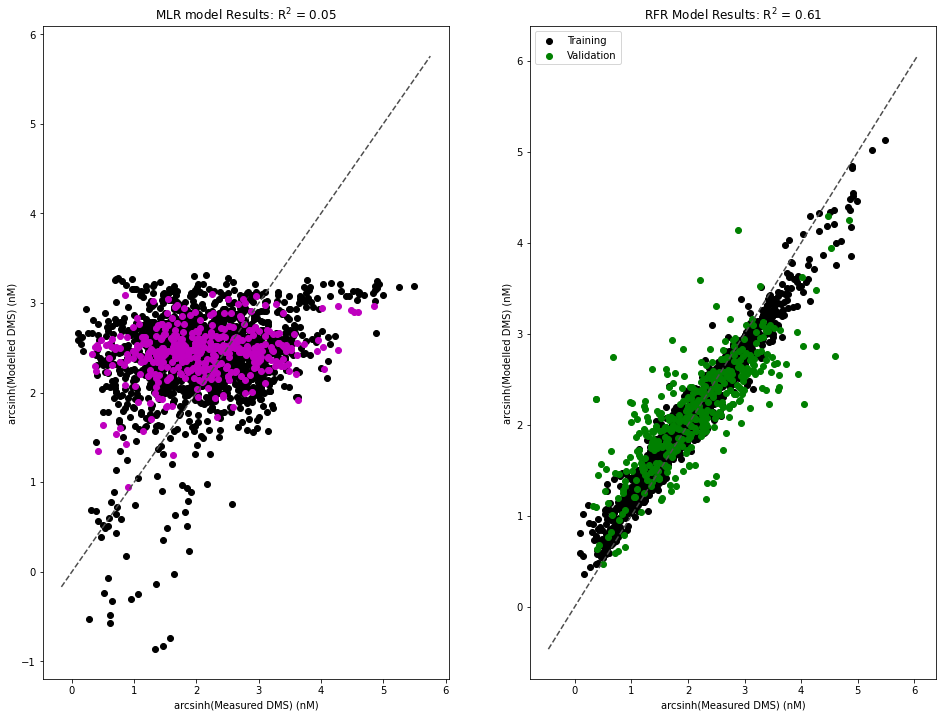

In [22]:
# Linear regression models (run 1 for each variable)
LM_preds = np.empty([y_test.shape[0],np.shape(X_test.columns)[0]])
LM_R2 = np.empty([np.shape(X_test.columns)[0],1])
LM_coef = np.empty([np.shape(X_test.columns)[0],1])
LM_RMSE = np.empty([np.shape(X_test.columns)[0],1])
lm = linear_model.LinearRegression()
i=0
for var_ in X_test.columns.values:
    LM_model = lm.fit(X_test.loc[:,[var_]],np.sinh(y_test))
    ypred_LM = lm.predict(X_test.loc[:,[var_]])
    LM_preds[:,i] = ypred_LM
    LM_R2[i,:] = lm.score(X_test.loc[:,[var_]],np.sinh(y_test))
    LM_coef[i,:] = lm.coef_
    LM_RMSE[i,:] = np.sqrt(metrics.mean_squared_error(np.sinh(y_test), ypred_LM))
    i+=1
print()
print('Linear Regression Results: ')
d = {'Variable':[x for x in X_test.columns.values],'Coefs':LM_coef[:,0],'R2':LM_R2[:,0],'RMSE':LM_RMSE[:,0]}
LM_results = pd.DataFrame(data=d).sort_values('RMSE')
print(LM_results)
print()

#MLR
lm_MLR = linear_model.LinearRegression()
MLR_model = lm_MLR.fit(X_train,np.sinh(y_train))
ypred_MLR_train = lm_MLR.predict(X_train) #y predicted by MLR

lm_MLR = linear_model.LinearRegression()
MLR_model = lm_MLR.fit(X_test,np.sinh(y_test))
ypred_MLR = lm_MLR.predict(X_test) #y predicted by MLR
intercept_MLR = lm_MLR.intercept_ #intercept predicted by MLR
coef_MLR = lm_MLR.coef_ #regression coefficients in MLR model
R2_MLR = lm_MLR.score(X_test,np.sinh(y_test)) #R-squared value from MLR model
RMSE_MLR = np.sqrt(metrics.mean_squared_error(np.sinh(y_test), ypred_MLR))

print('MLR results:')
print('a0 (intercept) = ' + str(intercept_MLR)[:5])
print('a1 = ' + str(coef_MLR[0])[:5]+' ('+X.columns.values[0]+')')
print('a2 = ' + str(coef_MLR[1])[:5]+' ('+X.columns.values[1]+')')
print('a3 = ' + str(coef_MLR[2])[:5]+' ('+X.columns.values[2]+')')
print('a4 = ' + str(coef_MLR[3])[:5]+' ('+X.columns.values[3]+')')
print('a5 = ' + str(coef_MLR[4])[:5]+' ('+X.columns.values[4]+')')
print('a6 = ' + str(coef_MLR[5])[:5]+' ('+X.columns.values[5]+')')
print('a7 = ' + str(coef_MLR[6])[:5]+' ('+X.columns.values[6]+')')
print('a8 = ' + str(coef_MLR[7])[:5]+' ('+X.columns.values[7]+')')
# print('a9 = ' + str(coef_MLR[7])[:5]+' ('+X.columns.values[8]+')')
print('')
print('R^2 = ' + str(R2_MLR)[:4])
print('RMSE = ' + str(RMSE_MLR)[:4])
print('')

#visualize MLR model performance
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(121)
ax.scatter(y_train,np.arcsinh(ypred_MLR_train),c='k')
ax.scatter(y_test,np.arcsinh(ypred_MLR),c='m')
l1 = np.min(ax.get_xlim())
l2 = np.max(ax.get_xlim())
ax.plot([l1,l2], [l1,l2], ls="--", c=".3")
ax.set_xlabel('arcsinh(Measured DMS) (nM)')
ax.set_ylabel('arcsinh(Modelled DMS) (nM)')
ax.set_title('MLR model Results: R${^2}$ = ' + str(R2_MLR)[:4])

ax2 = fig.add_subplot(122)
ax2.scatter(y_train,RFR_model.predict(X_train),c='k', label="Training")
ax2.scatter(y_test,RFR_model.predict(X_test),c='g', label="Validation")
l1 = np.min(ax.get_xlim())
l2 = np.max(ax.get_xlim())
ax2.plot([l1,l2], [l1,l2], ls="--", c=".3")
ax2.set_xlabel('arcsinh(Measured DMS) (nM)')
ax2.set_ylabel('arcsinh(Modelled DMS) (nM)')
ax2.set_title('RFR Model Results: R${^2}$ = ' + str(RFR_model_R2)[:4])
ax2.legend(loc='upper left')

## Build empirical DMS models from the literature for comparison

In [23]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# descale X values:
X_test_orig = pd.DataFrame(scaler.inverse_transform(X_test), index=X_test.index, columns=X_test.columns)
#-----------------------------------------------------------------------------
#### SD02 - Simo & Dachs (2002)

# First run model with global coefs from paper:
global_coefs = np.array([5.7, 55.8, 0.6])
def SD02_model(X, a,b,c):
    coefs = np.array([a,b,c])
    # Chl = X.loc[:,['Chlorophyll a']].values
    Chl = Chl_test.values
    MLD = X.loc[:,['MLD']].values
    Chl_MLD = Chl/MLD
    SD02 = np.empty([Chl.shape[0],Chl.shape[1]])
    for i, val in enumerate(Chl_MLD):
        if val < 0.02:
            SD02[i,0] = -np.log(MLD[i])+coefs[0]
        elif val >= 0.02:
            SD02[i,0] = coefs[1]*(Chl_MLD[i])+coefs[2]
    SD02 = SD02[:,0]
    return SD02
SD02 = SD02_model(X_test_orig, global_coefs[0], global_coefs[1], global_coefs[2])

# Now optimize for NE Pacific using least squares:
w, _ = scipy.optimize.curve_fit(SD02_model, X_test_orig, np.sinh(y_test), p0=global_coefs)
SD02_ls_optimized = SD02_model(X_test_orig, w[0], w[1], w[2])

# Now transform to compare:
SD02 = np.arcsinh(SD02)
SD02_ls_optimized = np.arcsinh(SD02_ls_optimized)
#-----------------------------------------------------------------------------
#### W07 - Watanabe et al. (2007)

# First run model with global coefs from paper:
global_coefs = np.array([0.06346,0.1210,14.11,6.278])
def W07_model(X,a,b,c,d):
    coefs = np.array([a,b,c,d])
    L = X.index.get_level_values('latbins').values
    SST = X.loc[:,['SST']].values+273.15 # units are in Kelvin
    SSN = X.loc[:,['SSN']].values
    W07 = np.log(np.exp((coefs[0]*SST)-(coefs[1]*SSN)-(coefs[2]*np.cos(L.reshape(-1,1).astype(float)))-coefs[3]))
    W07 = W07[:,0]
    return W07
W07 = W07_model(X_test_orig, global_coefs[0], global_coefs[1],global_coefs[2],global_coefs[3])

# Now optimize for NE Pacific using least squares:
w, _ = scipy.optimize.curve_fit(W07_model, X_test_orig, np.sinh(y_test), p0=global_coefs)
W07_ls_optimized = W07_model(X_test_orig, w[0], w[1], w[2], w[3])

# Now transform to compare:
W07 = np.arcsinh(W07)
W07_ls_optimized = np.arcsinh(W07_ls_optimized)
#-----------------------------------------------------------------------------
#### VS07 - Vallina & Simo (2007)

# First run model with global coefs from paper:
global_coefs = np.array([0.492,0.019])
def VS07_model(X, a, b):
    coefs = np.array([a,b])
    PAR = X.loc[:,['PAR']].values
    # Kd = X.loc[:,['Kd (490 nm)']].values
    Kd = Kd_test.values
    MLD = X.loc[:,['MLD']].values
    z = MLD # surface depth in m
    SRD = (PAR/(Kd*MLD))*(1-np.exp(-Kd*z))
    VS07 = coefs[0]+(coefs[1]*SRD)
    VS07 = VS07[:,0]
    return VS07
VS07 = VS07_model(X_test_orig, global_coefs[0], global_coefs[1])

# Now optimize for NE Pacific using least squares:
w, _ = scipy.optimize.curve_fit(VS07_model, X_test_orig, np.sinh(y_test), p0=global_coefs)
VS07_ls_optimized = VS07_model(X_test_orig, w[0], w[1])

# Now transform to compare:
VS07 = np.arcsinh(VS07)
VS07_ls_optimized = np.arcsinh(VS07_ls_optimized)
#-----------------------------------------------------------------------------
#### G18 - Gali et al. (2018)

# First run model with global coefs from paper:
global_coefs = np.array([1.237,0.578,0.0180])
def G18_model(X,a,b,c):
    coefs = np.array([a,b,c])
    # Kd = X.loc[:,['Kd (490 nm)']].values
    Kd = Kd_test.values
    MLD = X.loc[:,['MLD']].values
    # Chl = X.loc[:,['Chlorophyll a']].values
    Chl = Chl_test.values
    SST = X.loc[:,['SST']].values
    PAR = X.loc[:,['PAR']].values
    
    Z_eu = 4.6/Kd # euphotic layer depth
    Z_eu_MLD = Z_eu/MLD
    DMSPt = np.empty([MLD.shape[0], MLD.shape[1]])
    for i,val in enumerate(Z_eu_MLD):
        if val >= 1:
            DMSPt[i,0] = (1.70+(1.14*np.log10(Chl[i]))\
                              +(0.44*np.log10(Chl[i]**2))\
                                  +(0.063*SST[i])-(0.0024*(SST[i]**2)))
        elif val < 1:
            DMSPt[i,0] = (1.74+(0.81*np.log10(Chl[i]))+(0.60*np.log10(Z_eu_MLD[i])))
    G18 = -coefs[0]+(coefs[1]*DMSPt)+(coefs[2]*PAR)
    G18 = 10**(G18[:,0])
    return G18
G18 = G18_model(X_test_orig, global_coefs[0],global_coefs[1],global_coefs[2])

# Now optimize for NE Pacific using least squares:
w, _ = scipy.optimize.curve_fit(G18_model, X_test_orig, np.sinh(y_test), p0=global_coefs)
G18_ls_optimized = G18_model(X_test_orig, w[0], w[1], w[2])

# Now transform to compare:
G18 = np.arcsinh(G18)
G18_ls_optimized = np.arcsinh(G18_ls_optimized)

## Calculate taylor diagram statistics

In [24]:
# Generate random indices to subset by
# ANN_subset = int(0.1*num_models) # commented out; this is only relevant during development (i.e. less models = quicker testing); will match RFR subset when final 1000 model ensemble is used
ANN_subset = 1000
RFR_subset = 1000
np.random.seed(0)
RFR_rand_inds = np.random.choice(num_models,size=ANN_subset)
ANN_rand_inds = np.random.choice(num_models,size=RFR_subset)
#-----------------------------------------------------------------------------
# Calculate the std of DMS data
stdrefs = y_test.std()
#-----------------------------------------------------------------------------
# Calculate SDs, pearson correlations for ensemble model:
std_ensemble = RFR_model.predict(X_test).std()
# std_ensemble = y_pred_subset.std()/y.std() #normalized
corrcoef_ensemble = pearsonr(RFR_model.predict(X_test),y_test)[0]
R2_ensemble = r2_score(y_test, RFR_model.predict(X_test))
#-----------------------------------------------------------------------------
# Calcuate stds, pearson correlations for RFR trees in ensemble:
# ntrees = 1000

stds = np.std([single_tree.predict(X_test) for single_tree in np.random.choice(RFR_model.estimators_,size=RFR_subset)],axis=1)
# stds = np.std([np.sinh(single_tree.predict(scaler.transform(X))) for single_tree in RFR_model.estimators_[:ntrees]],axis=1)

corrcoefs = np.empty([np.random.choice(RFR_model.estimators_,size=RFR_subset).shape[0]])
for i, single_tree in enumerate(np.random.choice(RFR_model.estimators_,size=RFR_subset)):
    rs = pearsonr(single_tree.predict(X_test), y_test)
    # rs = pearsonr(np.sinh(single_tree.predict(scaler.transform(X))), y)
    corrcoefs[i] = rs[0]

RMSE = np.empty([np.random.choice(RFR_model.estimators_,size=RFR_subset).shape[0]])
for i, single_tree in enumerate(np.random.choice(RFR_model.estimators_,size=RFR_subset)):
    rmses = np.sqrt(metrics.mean_squared_error(y_test, single_tree.predict(X_test)))
    # rmses = rmse(np.sinh(single_tree.predict(scaler.transform(X))), y)
    RMSE[i] = rmses
    
#-----------------------------------------------------------------------------
# Calcuate stds, pearson correlations for members in ANN ensemble:

ANN_stds = np.std([y_test_pred[model] for model in ANN_rand_inds],axis=1)

ANN_corrcoefs = np.empty([ANN_rand_inds.shape[0]])
for i, ind in enumerate(ANN_rand_inds):
    rs = pearsonr(y_test_pred[ind], y_test)
    # rs = pearsonr(np.sinh(single_tree.predict(scaler.transform(X))), y)
    ANN_corrcoefs[i] = rs[0]

#-----------------------------------------------------------------------------
# Calculate stds, pearson correlations for linear regression models:
LM_stds = np.std(np.arcsinh(LM_preds), axis=0)

LM_corrcoefs = np.empty([LM_preds.shape[1]])
for i in range(LM_preds.shape[1]):
    rs = pearsonr(np.arcsinh(LM_preds[:,i]),y_test)
    LM_corrcoefs[i] = rs[0]
    
R2_LM = np.empty([LM_preds.shape[1]])
for i in range(LM_preds.shape[1]):
    R2_LM[i] = r2_score(y_test, np.arcsinh(LM_preds[:,i]))
#-----------------------------------------------------------------------------
# Calculate stds, pearson correlations for multiple linear regression model:
MLR_stds = np.std(np.arcsinh(ypred_MLR))
# MLR_stds = np.std(ypred_MLR)/y.std() #normalized

MLR_corrcoefs = pearsonr(np.arcsinh(ypred_MLR), y_test)[0]
#-----------------------------------------------------------------------------
# Calculate stds, pearson correlations for literature models:
SD02_stds = np.std(SD02, axis=0)
SD02_corrcoefs = pearsonr(SD02.flatten(), y_test)[0]
R2_SD02 = r2_score(y_test, SD02.flatten())
SD02_ls_optimized_stds = np.std(SD02_ls_optimized, axis=0)
SD02_ls_optimized_corrcoefs = pearsonr(SD02_ls_optimized.flatten(), y_test)[0]
R2_SD02_ls_optimized = r2_score(y_test, SD02_ls_optimized.flatten())

W07_stds = np.std(W07, axis=0)
W07_corrcoefs = pearsonr(W07.flatten(), y_test)[0]
R2_W07 = r2_score(y_test, W07.flatten())
W07_ls_optimized_stds = np.std(W07_ls_optimized, axis=0)
W07_ls_optimized_corrcoefs = pearsonr(W07_ls_optimized.flatten(), y_test)[0]
R2_W07_ls_optimized = r2_score(y_test, W07_ls_optimized.flatten())

VS07_stds = np.std(VS07, axis=0)
VS07_corrcoefs = pearsonr(VS07.flatten(), y_test)[0]
R2_VS07 = r2_score(y_test, VS07.flatten())
VS07_ls_optimized_stds = np.std(VS07_ls_optimized, axis=0)
VS07_ls_optimized_corrcoefs = pearsonr(VS07_ls_optimized.flatten(), y_test)[0]
R2_VS07_ls_optimized = r2_score(y_test, VS07_ls_optimized.flatten())

G18_stds = np.std(G18, axis=0)
G18_corrcoefs = pearsonr(G18.flatten(), y_test)[0]
R2_G18 = r2_score(y_test, G18.flatten())
G18_ls_optimized_stds = np.std(G18_ls_optimized, axis=0)
G18_ls_optimized_corrcoefs = pearsonr(G18_ls_optimized.flatten(), y_test)[0]
R2_G18_ls_optimized = r2_score(y_test, G18_ls_optimized.flatten())
#-----------------------------------------------------------------------------

np.max(R2_LM)

-0.17128276175953228

## Taylor Diagram

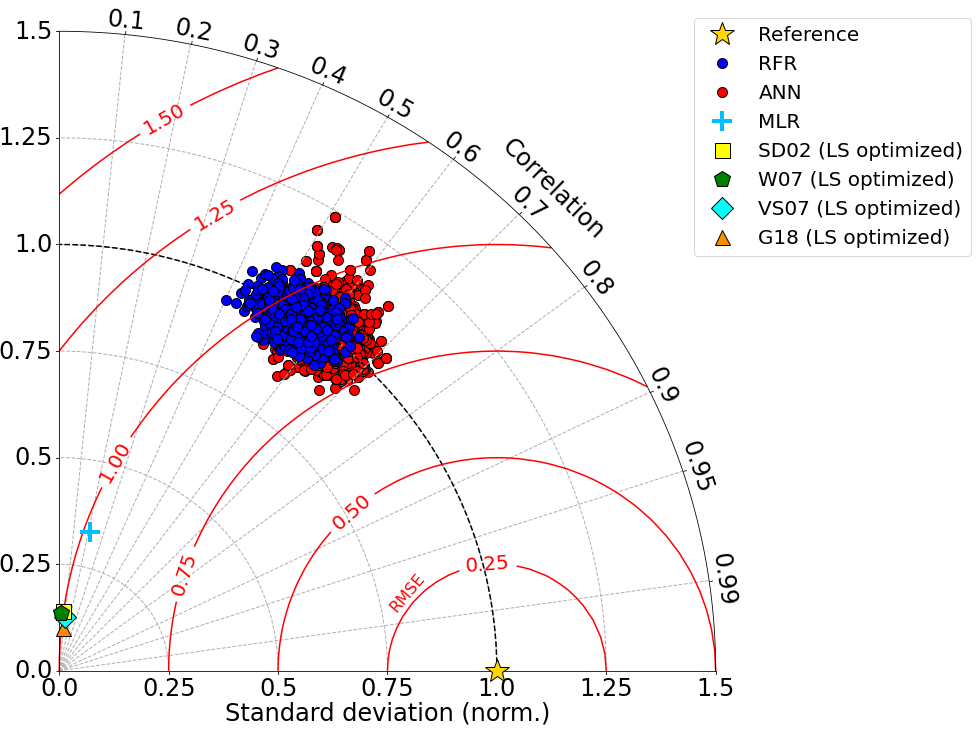

In [25]:
#-----------------------------------------------------------------------------
# Plot Taylor Diagram:
fig = plt.figure(figsize=(12,12))
font={'family':'sans-serif',
      'weight':'normal',
      'size':'24'} 
plt.rc('font', **font) # sets the specified font formatting globally

dia = TaylorDiagram(stdrefs, fig=fig, rect=111, srange=(0,1.5),
                    label='Reference', extend=False, normalize=True)

contours = dia.add_contours(levels=[0,0.25,0.5,0.75,1,1.25,1.5], colors='r')  # 5 levels in grey
plt.clabel(contours, inline=1, fontsize=20, fmt='%.2f')
dia.add_text(0.75,0.14,s='RMSE', fontsize=16, color='r', rotation=50)

# Add RFR values
dia.add_sample(stds, corrcoefs,
                        marker='o', ms=10, ls='',
                        mfc='b', mec='k',
                        label='RFR',
                        normalize=True,
                        zorder=2)


# ind = np.where(ANN_stds<=1)
ind = np.where(ANN_stds>=0)

# Add ANN values
dia.add_sample(ANN_stds, ANN_corrcoefs,
                        marker='o', ms=10, ls='',
                        mfc='r', mec='k',
                        label='ANN',
                        normalize=True,
                        zorder=1)

# Add LM values
# dia.add_sample(LM_stds, LM_corrcoefs,
#                        marker='x', ms=10, ls='', mew='4',
#                        mfc='m', mec='m',
#                        label="Linear Regression",
#                        normalize=True)
# Add MLR values
dia.add_sample(MLR_stds, MLR_corrcoefs,
                       marker='+', ms=20, ls='', mew='4',
                       mfc='k', mec='deepskyblue',
                       label="MLR",
                       normalize=True, zorder=10)

# Add Optimized SD02 values
dia.add_sample(SD02_ls_optimized_stds, SD02_ls_optimized_corrcoefs,
                       marker='s', ms=15, ls='', mew='1',
                       mfc='yellow', mec='k',
                       label="SD02 (LS optimized)",
                       normalize=True, zorder=11)
# Add Optimized W07 values
dia.add_sample(W07_ls_optimized_stds, W07_ls_optimized_corrcoefs,
                       marker='p', ms=17, ls='', mew='1',
                       mfc='g', mec='k',
                       label="W07 (LS optimized)",
                       normalize=True, zorder=12)
# Add Optimized VS07 values
dia.add_sample(VS07_ls_optimized_stds, VS07_ls_optimized_corrcoefs,
                       marker='D', ms=15, ls='', mew='1',
                       mfc='cyan', mec='k',
                       label="VS07 (LS optimized)",
                       normalize=True, zorder=10)

# Add Optimized G18 values
dia.add_sample(G18_ls_optimized_stds, G18_ls_optimized_corrcoefs,
                       marker='^', ms=15, ls='', mew='1',
                       mfc='darkorange', mec='k',
                       label="G18 (LS optimized)",
                       normalize=True, zorder=9)

# # Add SD02 values
# dia.add_sample(SD02_stds, SD02_corrcoefs,
#                        marker='s', ms=10, ls='', mew='1',
#                        mfc='r', mec='k',
#                        label="SD02",
#                        normalize=True)
# # Add W07 values
# dia.add_sample(W07_stds, W07_corrcoefs,
#                        marker='p', ms=12, ls='', mew='1',
#                        mfc='r', mec='k',
#                        label="W07",
#                        normalize=True)
# # Add VS07 values
# dia.add_sample(VS07_stds, VS07_corrcoefs,
#                        marker='D', ms=10, ls='', mew='1',
#                        mfc='r', mec='k',
#                        label="VS07",
#                        normalize=True)

# # Add G18 values
# dia.add_sample(G18_stds, G18_corrcoefs,
#                        marker='^', ms=10, ls='', mew='1',
#                        mfc='r', mec='k',
#                        label="G18",
#                        normalize=True)

dia._ax.axis[:].major_ticks.set_tick_out(True)
dia.add_grid(lw=1, ls='--')
fig.legend(dia.samplePoints,
                [ p.get_label() for p in dia.samplePoints ],
                numpoints=1, bbox_to_anchor=(1.2, 0.9), prop=dict(size='small'), loc='upper right', facecolor='none')

# plt.tight_layout()

fig.savefig(save_to_path+str('Taylor.png'), dpi=300, bbox_inches='tight')
fig.savefig(save_to_path+str('Fig02.pdf'), dpi=300, bbox_inches='tight')

## MLR vs. Ensemble Performance

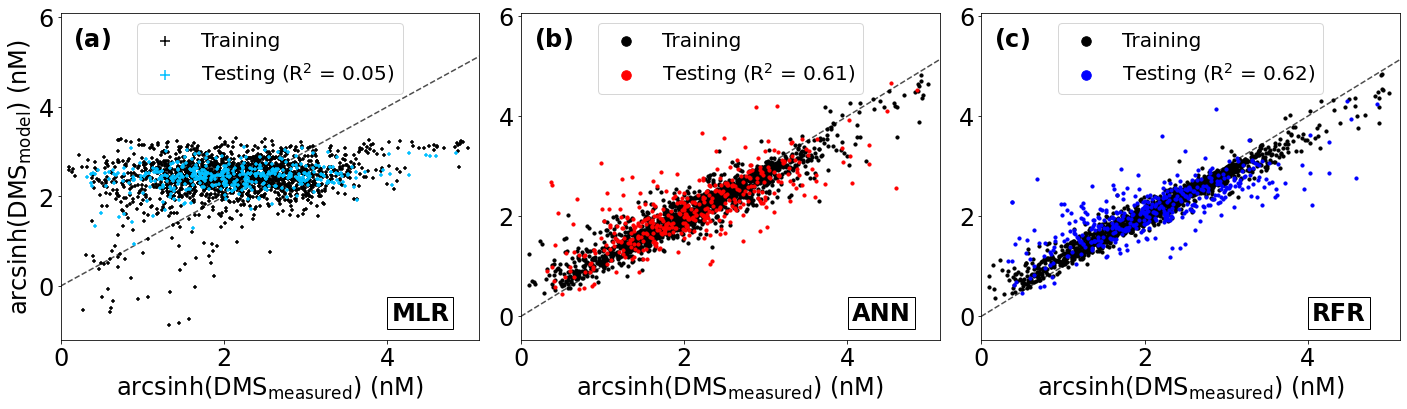

In [26]:
fig = plt.figure(figsize=(24, 6))
font={'family':'DejaVu Sans',
      'weight':'normal',
      'size':'24'} 
plt.rc('font', **font) # sets the specified font formatting globally
ax3=fig.add_subplot(131)
ax4=fig.add_subplot(132)
ax5=fig.add_subplot(133)
#-----------------------------------------------------------------------------
# Plot MLR Fit
# sns.regplot(x=y, y=np.arcsinh(ypred_MLR), scatter=False, color=".15", ax=ax3, label='R${^2}$ = ' + str(round(R2_MLR,2)))
# sns.scatterplot(x=y, y=np.arcsinh(ypred_MLR), s=5, color=".15", ax=ax3)
# sns.histplot(x=y, y=np.arcsinh(ypred_MLR), bins=100, pthresh=.1, cmap="mako", ax=ax3, **{"zorder":10})
# sns.kdeplot(x=y, y=ypred_MLR, levels=5, color="w", linewidths=1, ax=ax3)
ax3.scatter(y_train,np.arcsinh(ypred_MLR_train),s=10,c='k',marker='+',label='Training')
ax3.scatter(y_test,np.arcsinh(ypred_MLR),s=10,c='deepskyblue',marker='+',label='Testing (R${^2}$ = ' + str(round(R2_MLR,2))+')')
l1 = np.min(ax3.get_xlim())
l2 = np.max(ax3.get_xlim())
ax3.plot([l1,l2], [l1,l2], ls="--", c=".3", zorder=0)
# ax4.set_ylim([np.arcsinh(ypred_MLR.min()),np.arcsinh(ypred_MLR.max())])
ax3.set_xlim([0, y_pred_subset.max()])
ax3.set_xlabel(r'arcsinh(DMS$_{\rmmeasured}$) (nM)')
ax3.set_ylabel(r'arcsinh(DMS$_{\rmmodel}$) (nM)')
# ax3.set_title('MLR')
ax3.legend(loc='upper center', markerscale=3, fontsize=20, facecolor='none')
ax3.text(0.79,0.06,'MLR', transform=ax3.transAxes, fontweight='bold',bbox=dict(facecolor='none',edgecolor='k'))
ax3.text(0.03,0.9,'$\mathbf{(a)}$',fontsize='24',transform=ax3.transAxes)
#-----------------------------------------------------------------------------
# Plot ANN Fit
# sns.regplot(x=y, y=y_pred_subset, scatter=False, color=".15", ax=ax4, label='R${^2}$ = ' + str(round(RFR_model_R2,2)))
# sns.scatterplot(x=y, y=y_pred_subset, s=5, color=".15", ax=ax4)
# sns.histplot(x=y, y=y_pred_subset, bins=100, pthresh=.1, cmap="mako", ax=ax4, **{"zorder":10})
# sns.kdeplot(x=y, y=y_pred_subset, levels=5, color="w", linewidths=1, ax=ax4)
ax4.scatter(y_train,ANN_y_train_predict,s=10,c='k', label="Training")
ax4.scatter(y_test,ANN_y_test_predict,s=10,c='r', label="Testing (R${^2}$ = "+ str(round(ANN_model_R2,2))+")")
l1 = np.min(ax4.get_xlim())
l2 = np.max(ax4.get_xlim())
ax4.plot([l1,l2], [l1,l2], ls="--", c=".3", zorder=0)
# ax4.set_ylim([np.arcsinh(ypred_MLR.min()),np.arcsinh(ypred_MLR.max())])
ax4.set_xlim([0, y_pred_subset.max()])
ax4.set_xlabel(r'arcsinh(DMS$_{\rmmeasured}$) (nM)')
# ax4.set_ylabel(r'arcsinh(DMS$_{\rmmodel}$) (nM)')
# ax4.set_title('ANN')
ax4.legend(loc='upper center', markerscale=3, fontsize=20, facecolor='none')
ax4.text(0.79,0.06,'ANN', transform=ax4.transAxes,fontweight='bold',bbox=dict(facecolor='none',edgecolor='k'))
ax4.text(0.03,0.9,'$\mathbf{(b)}$',fontsize='24',transform=ax4.transAxes)
#-----------------------------------------------------------------------------
# Plot RFR Fit
# sns.regplot(x=y, y=y_pred_subset, scatter=False, color=".15", ax=ax5, label='R${^2}$ = ' + str(round(RFR_model_R2,2)))
# sns.scatterplot(x=y, y=y_pred_subset, s=5, color=".15", ax=ax5)
# sns.histplot(x=y, y=y_pred_subset, bins=100, pthresh=.1, cmap="mako", ax=ax5, **{"zorder":10})
# sns.kdeplot(x=y, y=y_pred_subset, levels=5, color="w", linewidths=1, ax=ax5)
ax5.scatter(y_train,RFR_model.predict(X_train),s=10,c='k', label="Training")
ax5.scatter(y_test,RFR_model.predict(X_test),s=10,c='b', label="Testing (R${^2}$ = "+ str(round(RFR_model_R2,2))+")")
l1 = np.min(ax5.get_xlim())
l2 = np.max(ax5.get_xlim())
ax5.plot([l1,l2], [l1,l2], ls="--", c=".3", zorder=0)
# ax5.set_ylim([np.arcsinh(ypred_MLR.min()),np.arcsinh(ypred_MLR.max())])
ax5.set_xlim([0, y_pred_subset.max()])
ax5.set_xlabel(r'arcsinh(DMS$_{\rmmeasured}$) (nM)')
# ax5.set_ylabel(r'arcsinh(DMS$_{\rmmodel}$) (nM)')
# ax5.set_title('RFR')
ax5.legend(loc='upper center', markerscale=3, fontsize=20, facecolor='none')
ax5.text(0.79,0.06,'RFR', transform=ax5.transAxes,fontweight='bold',bbox=dict(facecolor='none',edgecolor='k'))
ax5.text(0.03,0.9,'$\mathbf{(c)}$',fontsize='24',transform=ax5.transAxes)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig.subplots_adjust(hspace=2)
fig.subplots_adjust(wspace=0.1)

fig.savefig(save_to_path+str('Ensemble_performance.png'), dpi=300, transparent=True, bbox_inches='tight')
fig.savefig(save_to_path+str('Fig03.pdf'), dpi=300, transparent=True, bbox_inches='tight')

## Sea-air flux histograms

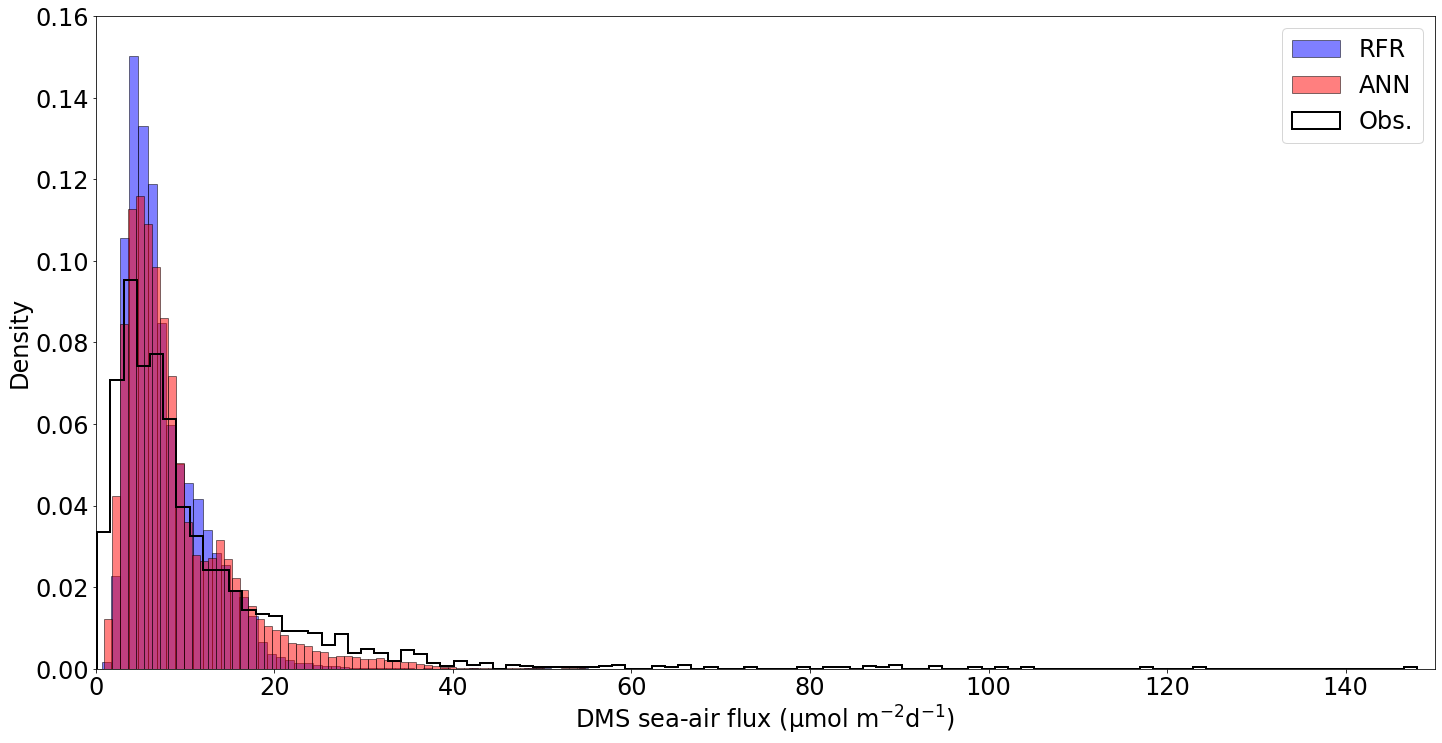

In [27]:

fig = plt.figure(figsize=(24,12))
#------------------------------------------------------------------------------
ax = fig.add_subplot(111)
ax.hist([flux_pred.values[:,0]], histtype='bar', bins=100, density=True,  edgecolor='black', fc='b', alpha=0.5, label='RFR')
ax.hist([ANN_flux_pred.values[:,0]], histtype='bar', bins=100, density=True,  edgecolor='black', fc='r', alpha=0.5, label='ANN')
ax.hist([flux_meas.values[:,0]], histtype='step',bins=100, density=True, stacked=True, edgecolor='k', fc='g', lw=2, alpha=1, label='Obs.')
ax.set_ylabel(r'Density')
ax.set_xlabel(r'DMS sea-air flux ($\mathrm{\mu}$mol $\mathrm{m^{-2} d^{-1}}$)')
ax.set_xlim(0,150)
ax.set_ylim(0,0.16)
ax.legend()
# ax.text(0.03,0.95,'$\mathbf{A}$',fontsize='24',transform=ax.transAxes, zorder=500)
# ax.set_title('n = '+str(flux_pred.shape[0]))
#------------------------------------------------------------------------------
# ax2 = fig.add_subplot(212)
# ax2.hist([flux_meas.values[:,0]], histtype='bar',bins=100, density=True, stacked=True, edgecolor='black', fc='g', alpha=0.5, label='Obs.')
# ax2.set_ylabel(r'Density')
# ax2.set_xlabel(r'DMS flux ($\mathrm{\mu}$mol $\mathrm{m^{-2} d^{-1}}$)')
# ax2.set_xlim(0,150)
# ax2.set_ylim(0,0.16)
# ax2.legend()
# ax2.text(0.05,0.9,'$\mathbf{B}$',fontsize='24',transform=ax2.transAxes, zorder=500)

fig.savefig(save_to_path+str('Flux_histograms.png'), dpi=300, bbox_inches='tight')
fig.savefig(save_to_path+str('Fig05.pdf'), dpi=300, bbox_inches='tight')

## Resolution sensitivity tests 

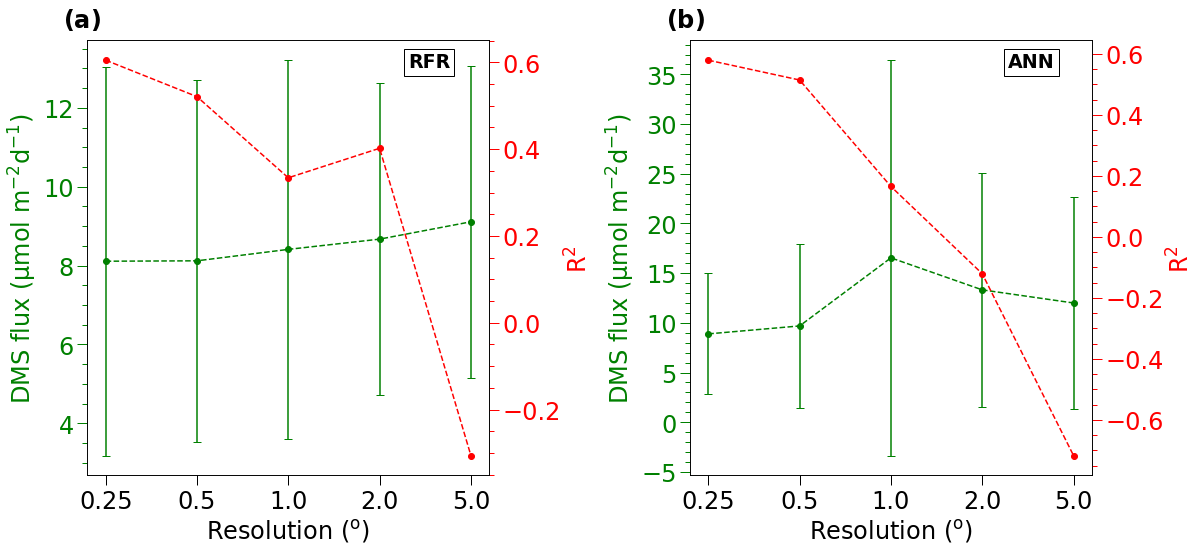

In [28]:

# This data was obtained from model runs at pixel resolutions between 0.25 to 5o

fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
axes = [ax, ax.twinx()]
axes[0].errorbar(np.array([0,1,2,3,4]),
                 np.array([8.11,8.12,8.41,8.67,9.11]),
                  yerr=np.array([4.93,4.59,4.8,3.96,3.96]),
                 capsize=4,
                 color='g',
                 ls='--',
                 marker='.',
                 ms=12)
axes[1].plot(np.array([0,1,2,3,4]),
                  np.array([0.605,0.521,0.334,0.402,-0.306]),
                 # np.array([0.527,0.494,0.573,0.510,0.784]),
                 color='r',
                 ls='--',
                 marker='.',
                 ms=12)
axes[0].set_xticks(np.array([0,1,2,3,4]))
axes[0].set_xticklabels(np.array([0.25,0.5,1,2,5]))
axes[0].set_ylabel('DMS flux ($\mathrm{\mu}$mol $\mathrm{m^{-2} d^{-1}}$)', color='g')
axes[1].set_ylabel('R$\mathrm{^{2}}$', color='r')
# axes[1].set_ylabel('RMSE', color='r')
axes[0].set_xlabel('Resolution ($\mathrm{^{o}}$)')
axes[0].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
axes[1].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
axes[0].tick_params('both', length=10, width=1, which='major')
axes[0].tick_params('both', length=5, width=1, which='minor')
axes[1].tick_params('both', length=10, width=1, which='major')
axes[1].tick_params('both', length=5, width=1, which='minor')
axes[0].tick_params(axis='y', which='both', colors='g')
axes[1].tick_params(axis='y', which='both', colors='r')

axes[0].text(0.85, 0.95, 'RFR', transform=axes[0].transAxes, fontsize=19, fontweight='bold',
        va='center', ha='center', bbox=dict(facecolor='white', alpha=1), zorder=500)
axes[0].text(-0.06,1.03,'$\mathbf{(a)}$',fontsize='24',transform=axes[0].transAxes)
#------------------------------------------------------------------------------
axes = [ax2, ax2.twinx()]
axes[0].errorbar(np.array([0,1,2,3,4]),
                 np.array([8.89,9.69,16.54,13.32,12.0]),
                 yerr=np.array([6.09,8.29,19.89,11.78,10.65]),
                 capsize=4,
                 color='g',
                 ls='--',
                 marker='.',
                 ms=12)
axes[1].plot(np.array([0,1,2,3,4]),
                  np.array([0.579,0.514,0.165,-0.121,-0.717]),
                 # np.array([0.544,0.4982,0.6373,0.6984,0.8986]),
                 color='r',
                 ls='--',
                 marker='.',
                 ms=12)
axes[0].set_xticks(np.array([0,1,2,3,4]))
axes[0].set_xticklabels(np.array([0.25,0.5,1,2,5]))
axes[0].set_ylabel('DMS flux ($\mathrm{\mu}$mol $\mathrm{m^{-2} d^{-1}}$)', color='g')
axes[1].set_ylabel('R$\mathrm{^{2}}$', color='r')
# axes[1].set_ylabel('RMSE', color='r')
axes[0].set_xlabel('Resolution ($\mathrm{^{o}}$)')
axes[0].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
axes[1].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
axes[0].tick_params('both', length=10, width=1, which='major')
axes[0].tick_params('both', length=5, width=1, which='minor')
axes[1].tick_params('both', length=10, width=1, which='major')
axes[1].tick_params('both', length=5, width=1, which='minor')
axes[0].tick_params(axis='y', which='both', colors='g')
axes[1].tick_params(axis='y', which='both', colors='r')

axes[0].text(0.85, 0.95, 'ANN', transform=axes[0].transAxes, fontsize=19, fontweight='bold',
        va='center', ha='center', bbox=dict(facecolor='white', alpha=1), zorder=500)
axes[0].text(-0.06,1.03,'$\mathbf{(b)}$',fontsize='24',transform=axes[0].transAxes)

fig.subplots_adjust(wspace=0.5)

fig.savefig(save_to_path+str('Resolution_sensitivity.png'), dpi=300, bbox_inches='tight')
fig.savefig(save_to_path+str('Fig01.pdf'), dpi=300, bbox_inches='tight')

## Calculate deviance between models

In [29]:
deviance = np.sinh(y_pred_mean)-np.sinh(ANN_y_pred_mean)
deviance = deviance.stack()
abs_deviance = abs(deviance)
print('Mean Deviance between RFR & ANN:')
print(str(round(abs(np.nanmean(deviance)),2))+' nM')
thres = 2
print('Number of pixels where deviance in predictions exceed '+str(thres)+' nM:')
print(str(abs_deviance[abs_deviance>thres].shape[0])+' or '+str(round((abs_deviance[abs_deviance>thres].shape[0]/abs_deviance.shape[0])*100, 1))+'%')

Mean Deviance between RFR & ANN:
0.4 nM
Number of pixels where deviance in predictions exceed 2 nM:
628 or 3.8%


## Visualize models & deviance

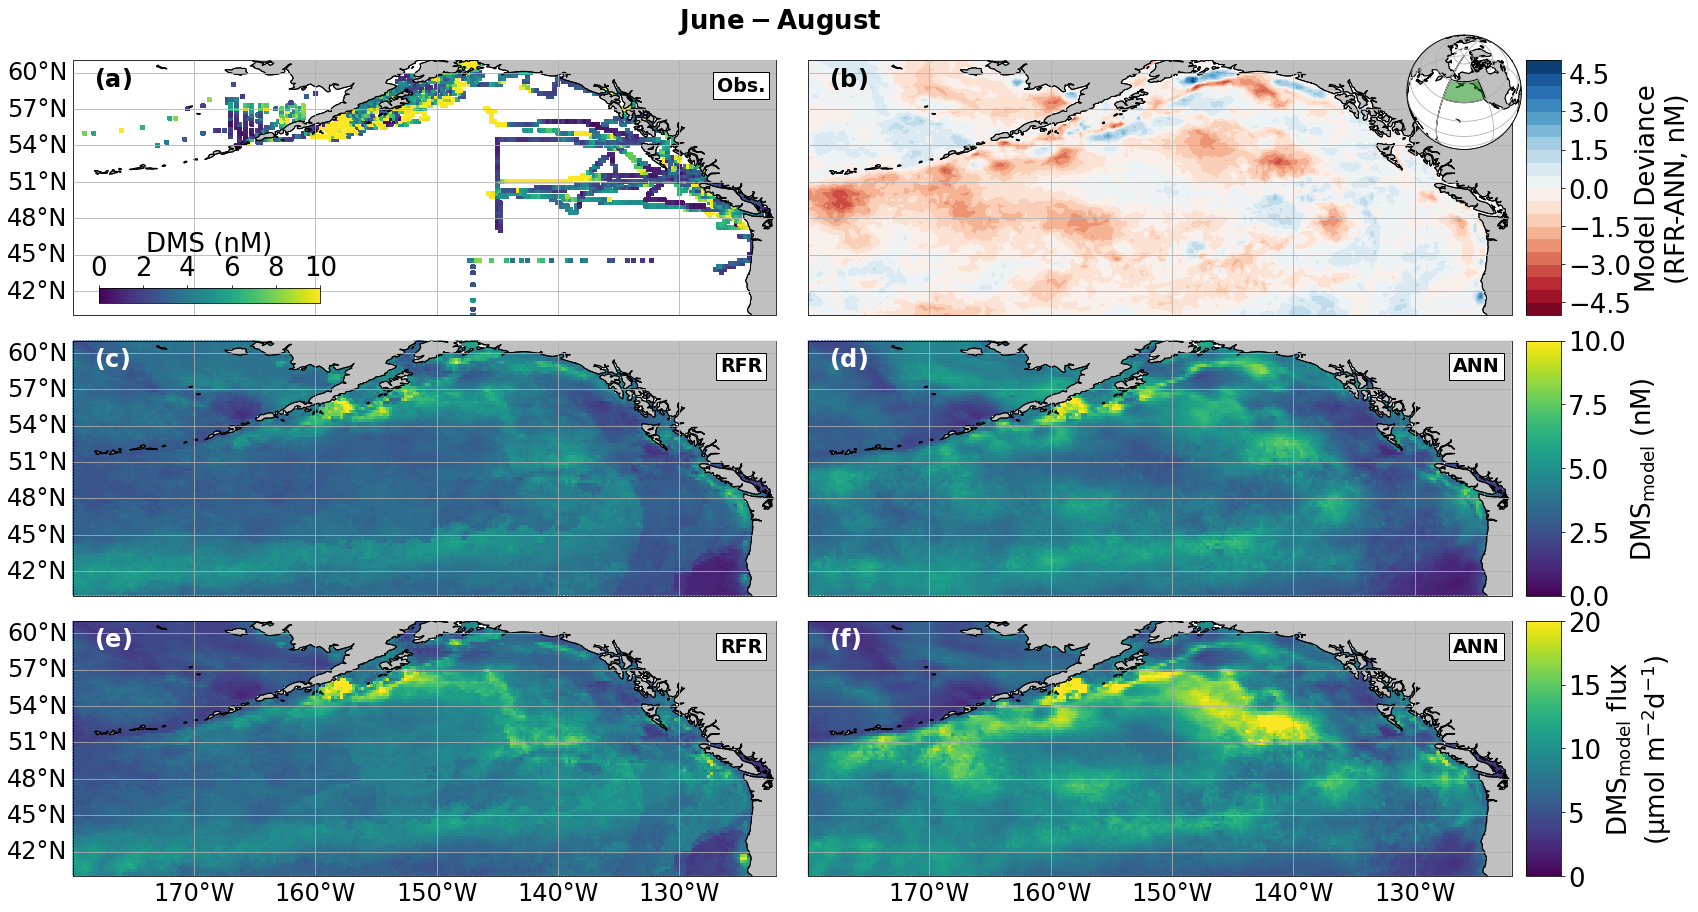

In [30]:
sizing = 26 # 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set-up fig
fig = plt.figure(figsize=(28,15))
font={'family':'DejaVu Sans',
      'weight':'normal',
      'size':'24'} 
plt.rc('font', **font) # sets the specified font formatting globally
gs = fig.add_gridspec(3, 4)
# main plots
ax = fig.add_subplot(gs[0,0:2], projection=ccrs.PlateCarree())
ax6 = fig.add_subplot(gs[0,2:4], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1,0:2], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[1,2:4], projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[2,0:2], projection=ccrs.PlateCarree())
ax5 = fig.add_subplot(gs[2,2:4], projection=ccrs.PlateCarree())

cmap = plt.cm.viridis
vmin = 0
vmax = 10
vmax_flux = 20
#------------------------------------------------------------------------------
#### Measured
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, zorder=101)
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False
# if kk != 0:
#     gl.left_labels = False
ax.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
ax.add_feature(cartopy.feature.COASTLINE, zorder=100, edgecolor='k')
h1 = ax.pcolormesh(y_meas_mean.columns.values,
                   y_meas_mean.index.values,
                   np.sinh(y_meas_mean.values),
                   shading='nearest',
                   cmap=cmap,
                   vmin = vmin, vmax = vmax,
                   transform=ccrs.PlateCarree())
h1.set_edgecolor("face")

# divider = make_axes_locatable(ax)
# ax_cb = divider.new_horizontal(size="5%", pad=0.2, axes_class=plt.Axes)
# fig.add_axes(ax_cb)
ax_cb = inset_axes(ax, width="35%", height="20%", loc='lower left',
                    bbox_to_anchor=(0.02, 0, 0.9, 0.3), bbox_transform=ax.transAxes)
cb1 = plt.colorbar(h1, cax=ax_cb, orientation='horizontal')
cb1.ax.tick_params(labelsize=sizing)
cb1.set_ticks([0,2,4,6,8,10])
cb1.set_label('DMS (nM)', fontsize=sizing)
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')
ax.text(0.03,0.9,'$\mathbf{(a)}$',fontsize='24',transform=ax.transAxes, zorder=500)

ax.text(0.95, 0.9, 'Obs.', transform=ax.transAxes, fontsize=19, fontweight='bold',
        va='center', ha='center', bbox=dict(facecolor='white', alpha=1), zorder=500)

plt.suptitle(r'$\bf{June-August}$', y=0.93, fontsize=sizing)
#------------------------------------------------------------------------------
#### Deviance
ax6.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
gl = ax6.gridlines(draw_labels=True, zorder=101)
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False
gl.left_labels = False

norm = mpl.colors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5) # scales to accentuate depth colors, and diverge at 0

ax6.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
ax6.add_feature(cartopy.feature.COASTLINE, zorder=100, edgecolor='k')
h2 = ax6.contourf(y_pred_mean.columns.values,
                    y_pred_mean.index.values,
                    # np.sinh(y_pred_mean).values-np.sinh(ANN_y_pred_mean).values,
                    deviance.unstack().values,
                    levels = 20,
                    # shading='nearest',
                    norm=norm,
                    cmap='RdBu',
                    vmin = -5, vmax = 5,
                    transform=ccrs.PlateCarree())
# for h in h2.collections:
#     h.set_edgecolor("face")

# if kk == 2:
divider = make_axes_locatable(ax6)
ax_cb = divider.new_horizontal(size="5%", pad=0.2, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cb1 = plt.colorbar(h2, cax=ax_cb)
cb1.ax.tick_params(labelsize=sizing)
cb1.set_label('Model Deviance'+'\n(RFR-ANN, nM)', fontsize=sizing)
# ax.set_title(r"$\bf{" + str(dates[kk]) +"}$", fontsize=24)
ax6.text(0.03,0.9,'$\mathbf{(b)}$',fontsize='24',color='k', transform=ax6.transAxes, zorder=500)
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
# Mini global map code adapted from here: https://stackoverflow.com/questions/45527584/how-to-easily-add-a-sub-axes-with-proper-position-and-size-in-matplotlib-and-car
map_proj = ccrs.Orthographic(
    central_latitude=(min_lat + max_lat) / 2,
    central_longitude=(min_lon + max_lon) / 2)
map_proj._threshold /= 100 #increases map resolution for drawing polygons

ax7 = inset_axes(ax6, width="100%", height="100%", loc="lower left", 
               axes_class=cartopy.mpl.geoaxes.GeoAxes, 
               axes_kwargs=dict(map_projection=map_proj))
ax7.set_global()
ax7.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='silver')
ax7.add_feature(cartopy.feature.OCEAN, edgecolor='k', facecolor='w')
ax7.gridlines(draw_labels=False)

ax7.add_patch(mpl.patches.Rectangle(xy=(min_lon, min_lat), width=max_lon-min_lon, height=max_lat-min_lat,
                                    facecolor='g',
                                    alpha=0.5,
                                    transform=ccrs.PlateCarree()))
ax7.add_patch(mpl.patches.Rectangle(xy=(min_lon, min_lat), width=max_lon-min_lon, height=max_lat-min_lat,
                                    ec='k',
                                    fill=False,
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))

# inset location relative to main plot (ax) in normalized units
inset_x = 0.82
inset_y = 0.65
inset_size = 0.45
ip = InsetPosition(ax6, [inset_x - inset_size / 4,
                        inset_y,
                        inset_size,
                        inset_size])
ax7.set_axes_locator(ip)
#------------------------------------------------------------------------------
#### RFR
ax2.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
gl = ax2.gridlines(draw_labels=True, zorder=101)
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False
# if kk != 0:
#     gl.left_labels = False
ax2.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
ax2.add_feature(cartopy.feature.COASTLINE, zorder=100, edgecolor='k')
h3 = ax2.pcolormesh(y_pred_mean.columns.values,
                    y_pred_mean.index.values,
                    np.sinh(y_pred_mean.values),
                    shading='nearest',
                    cmap=cmap,
                    vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree())
h3.set_edgecolor("face")
ax2.text(0.03,0.9,'$\mathbf{(c)}$',fontsize='24', color='w', transform=ax2.transAxes, zorder=500)

ax2.text(0.95, 0.9, 'RFR', transform=ax2.transAxes, fontsize=19, fontweight='bold',
        va='center', ha='center', bbox=dict(facecolor='white', alpha=1), zorder=500)
#------------------------------------------------------------------------------
#### ANN
ax3.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
gl = ax3.gridlines(draw_labels=True, zorder=101)
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False
# if kk != 0:
gl.left_labels = False
ax3.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
ax3.add_feature(cartopy.feature.COASTLINE, zorder=100, edgecolor='k')
h4 = ax3.pcolormesh(ANN_y_pred_mean.columns.values,
                    ANN_y_pred_mean.index.values,
                    np.sinh(ANN_y_pred_mean.values),
                    shading='nearest',
                    cmap=cmap,
                    vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree())
h4.set_edgecolor("face")

# if kk == 2:
divider = make_axes_locatable(ax3)
ax_cb = divider.new_horizontal(size="5%", pad=0.2, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cb1 = plt.colorbar(h4, cax=ax_cb)
cb1.ax.tick_params(labelsize=sizing)
cb1.set_label(r'DMS$_{\rmmodel}$ (nM)', fontsize=sizing)
# ax.set_title(r"$\bf{" + str(dates[kk]) +"}$", fontsize=24)
ax3.text(0.03,0.9,'$\mathbf{(d)}$',fontsize='24',color='w', transform=ax3.transAxes, zorder=500)

ax3.text(0.95, 0.9, 'ANN', transform=ax3.transAxes, fontsize=19, fontweight='bold',
        va='center', ha='center', bbox=dict(facecolor='white', alpha=1), zorder=500)

#------------------------------------------------------------------------------
#### RFR Flux
ax4.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
gl = ax4.gridlines(draw_labels=True, zorder=101)
gl.top_labels = False
gl.right_labels = False
# gl.bottom_labels = False
# if kk != 0:
#     gl.left_labels = False
ax4.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
ax4.add_feature(cartopy.feature.COASTLINE, zorder=100, edgecolor='k')
h5 = ax4.pcolormesh(flux_pred_mean.columns.values,
                    flux_pred_mean.index.values,
                    flux_pred_mean.values,
                    shading='nearest',
                    cmap=cmap,
                    vmin = vmin, vmax = vmax_flux,
                    transform=ccrs.PlateCarree())
h5.set_edgecolor("face")
ax4.text(0.03,0.9,'$\mathbf{(e)}$',fontsize='24',color='w', transform=ax4.transAxes, zorder=500)

ax4.text(0.95, 0.9, 'RFR', transform=ax4.transAxes, fontsize=19, fontweight='bold',
        va='center', ha='center', bbox=dict(facecolor='white', alpha=1), zorder=500)
#------------------------------------------------------------------------------
#### ANN Flux
ax5.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
gl = ax5.gridlines(draw_labels=True, zorder=101)
gl.top_labels = False
gl.right_labels = False
# gl.bottom_labels = False
# if kk != 0:
gl.left_labels = False
ax5.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
ax5.add_feature(cartopy.feature.COASTLINE, zorder=100, edgecolor='k')
h6 = ax5.pcolormesh(ANN_flux_pred_mean.columns.values,
                    ANN_flux_pred_mean.index.values,
                    ANN_flux_pred_mean.values,
                    shading='nearest',
                    cmap=cmap,
                    vmin = vmin, vmax = vmax_flux,
                    transform=ccrs.PlateCarree())
h6.set_edgecolor("face")

# if kk == 2:
divider = make_axes_locatable(ax5)
ax_cb = divider.new_horizontal(size="5%", pad=0.2, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cb1 = plt.colorbar(h6, cax=ax_cb)
cb1.ax.tick_params(labelsize=sizing)
cb1.set_label(r'DMS$_{\rmmodel}$ flux'+'\n'+r'($\mathrm{\mu}$mol $\mathrm{m^{-2} d^{-1}}$)', fontsize=sizing)
# ax.set_title(r"$\bf{" + str(dates[kk]) +"}$", fontsize=24)
ax5.text(0.03,0.9,'$\mathbf{(f)}$',fontsize='24',color='w', transform=ax5.transAxes, zorder=500)

ax5.text(0.95, 0.9, 'ANN', transform=ax5.transAxes, fontsize=19, fontweight='bold',
        va='center', ha='center', bbox=dict(facecolor='white', alpha=1), zorder=500)

fig.subplots_adjust(hspace=.1)
fig.subplots_adjust(wspace=-.1)

fig.savefig(save_to_path+str('Compare_models.png'), dpi=300, bbox_inches='tight')
fig.savefig(save_to_path+str('Fig04.pdf'), dpi=300, bbox_inches='tight')

## Visualize temporal trends

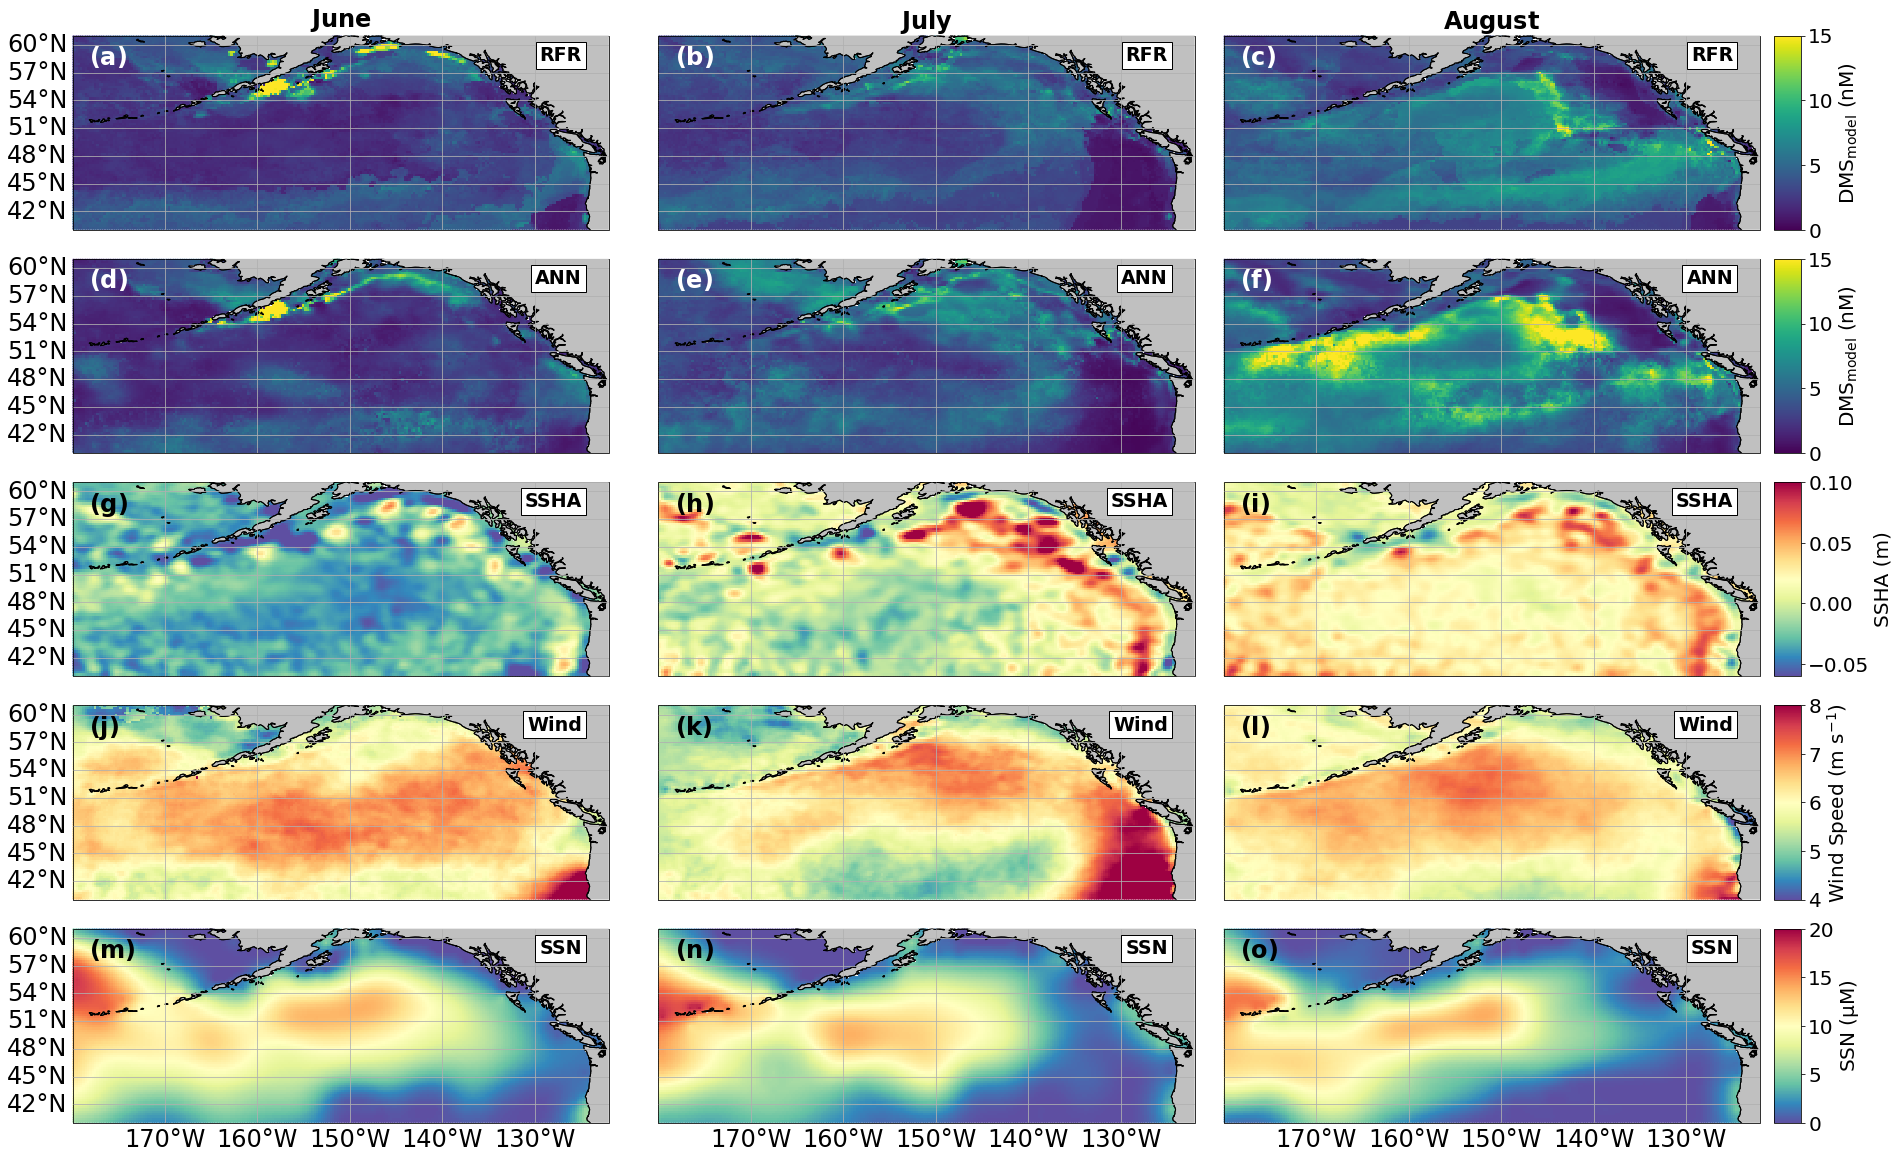

In [31]:

n = len(ys)

fig = plt.figure(figsize=(12*n,20))
cmap = plt.cm.viridis
dates = np.flip(np.unique(pd.to_datetime(arg=y_unstack.index.get_level_values('DateTime').values, format='%m').strftime('%B')))
date_ind = np.asarray([x[0] for x in X_full.index]).astype(float)
vmax=15
vmin=0

for kk in range(n):
    #--------------------------------------------------------------------------
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
    #### RFR
    ax = fig.add_subplot(5,n,kk+1, projection=ccrs.PlateCarree())
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, zorder=101)
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = False
    if kk != 0:
        gl.left_labels = False
    ax.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
    ax.add_feature(cartopy.feature.COASTLINE, zorder=100, edgecolor='k')
    h2 = ax.pcolormesh(y_preds[kk].columns.values,
              y_preds[kk].index.values,
              np.sinh(y_preds[kk].values),
              shading='nearest',
              cmap=cmap,
              vmin = vmin, vmax = vmax,
              transform=ccrs.PlateCarree())
    
    ax.text(0.95, 0.9, 'RFR', transform=ax.transAxes, fontsize=19, fontweight='bold',
            va='center', ha='right', bbox=dict(facecolor='white', alpha=1), zorder=500)
    
    if kk == 2:
        divider = make_axes_locatable(ax)
        ax_cb2 = divider.new_horizontal(size="5%", pad=0.2, axes_class=plt.Axes)
        fig.add_axes(ax_cb2)
        cb2 = plt.colorbar(h2, cax=ax_cb2)
        cb2.ax.tick_params(labelsize=20)
        cb2.set_label(r'DMS$_{\rmmodel}$ (nM)', fontsize=20)
    letters=['(a)','(b)','(c)']
    if kk == 2:
        ax.text(0.03,0.85,'$\mathbf{'+str(letters[kk])+'}$',fontsize='24', color='w', transform=ax.transAxes)
    else:
        ax.text(0.03,0.85,'$\mathbf{'+str(letters[kk])+'}$',fontsize='24', color='w', transform=ax.transAxes)
    ax.set_title(r"$\bf{" + str(dates[kk]) +"}$", fontsize=24)
    #--------------------------------------------------------------------------
    #### ANN
    ax2 = fig.add_subplot(5,n,(n+1)+kk, projection=ccrs.PlateCarree())
    ax2.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    gl = ax2.gridlines(draw_labels=True, zorder=101)
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = False
    if kk != 0:
        gl.left_labels = False
    ax2.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
    ax2.add_feature(cartopy.feature.COASTLINE, zorder=100, edgecolor='k')
    h4 = ax2.pcolormesh(ANN_y_preds[kk].columns.values,
                        ANN_y_preds[kk].index.values,
                        np.sinh(ANN_y_preds[kk].values),
                        shading='nearest',
                        cmap=cmap,
                        vmin = vmin, vmax = vmax,
                        transform=ccrs.PlateCarree())
    
    ax2.text(0.95, 0.9, 'ANN', transform=ax2.transAxes, fontsize=19, fontweight='bold',
            va='center', ha='right', bbox=dict(facecolor='white', alpha=1), zorder=500)
    
    if kk == 2:
        divider = make_axes_locatable(ax2)
        ax_cb4 = divider.new_horizontal(size="5%", pad=0.2, axes_class=plt.Axes)
        fig.add_axes(ax_cb4)
        cb4 = plt.colorbar(h4, cax=ax_cb4)
        cb4.ax.tick_params(labelsize=20)
        cb4.set_label(r'DMS$_{\rmmodel}$ (nM)', fontsize=20)
    letters=['(d)','(e)','(f)']
    if kk == 2:
        ax2.text(0.03,0.85,'$\mathbf{'+str(letters[kk])+'}$',fontsize='24', color='w', transform=ax2.transAxes)
    else:
        ax2.text(0.03,0.85,'$\mathbf{'+str(letters[kk])+'}$',fontsize='24', color='w', transform=ax2.transAxes)
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
    #### SSHA
    norm = mpl.colors.TwoSlopeNorm(vmin=-0.06, vcenter=0, vmax=0.1)

    ax4 = fig.add_subplot(5,n,(n*2+1)+kk, projection=ccrs.PlateCarree())
    ax4.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    gl = ax4.gridlines(draw_labels=True, zorder=101)
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = False
    if kk != 0:
        gl.left_labels = False
    ax4.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
    ax4.add_feature(cartopy.feature.COASTLINE, zorder=100, edgecolor='k')
    h3 = ax4.pcolormesh(X_full[date_ind==kk+6].loc[:,['SSHA']].unstack('lonbins').columns.get_level_values('lonbins').values,
                        X_full[date_ind==kk+6].loc[:,['SSHA']].unstack('lonbins').index.get_level_values('latbins').values,
                        X_full[date_ind==kk+6].loc[:,['SSHA']].unstack('lonbins').values,
                        shading='nearest',
                        cmap='Spectral_r',
#                         norm=norm,
                        vmin = -0.06, vmax = 0.1,
                        transform=ccrs.PlateCarree())
    
    ax4.text(0.95, 0.9, 'SSHA', transform=ax4.transAxes, fontsize=19, fontweight='bold',
            va='center', ha='right', bbox=dict(facecolor='white', alpha=1), zorder=500)
    
    if kk == 2:
        divider = make_axes_locatable(ax4)
        ax_cb3 = divider.new_horizontal(size="5%", pad=0.2, axes_class=plt.Axes)
        fig.add_axes(ax_cb3)
        cb3 = plt.colorbar(h3, cax=ax_cb3)
        cb3.ax.tick_params(labelsize=20)
        cb3.set_label(r'SSHA (m)', fontsize=20)
    letters=['(g)','(h)','(i)']
    if kk == 2:
        ax4.text(0.03,0.85,'$\mathbf{'+str(letters[kk])+'}$',fontsize='24',transform=ax4.transAxes)
    else:
        ax4.text(0.03,0.85,'$\mathbf{'+str(letters[kk])+'}$',fontsize='24',transform=ax4.transAxes)
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
    #### Wind Speed
    ax6 = fig.add_subplot(5,n,(n*3+1)+kk, projection=ccrs.PlateCarree())
    ax6.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    gl = ax6.gridlines(draw_labels=True, zorder=101)
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = False
    if kk != 0:
        gl.left_labels = False
    ax6.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
    ax6.add_feature(cartopy.feature.COASTLINE, zorder=100, edgecolor='k')
    h3 = ax6.pcolormesh(X_full[date_ind==kk+6].loc[:,['Wind Speed']].unstack('lonbins').columns.get_level_values('lonbins').values,
                        X_full[date_ind==kk+6].loc[:,['Wind Speed']].unstack('lonbins').index.get_level_values('latbins').values,
                        X_full[date_ind==kk+6].loc[:,['Wind Speed']].unstack('lonbins').values,
                        shading='nearest',
                        cmap='Spectral_r',
                        # norm=norm,
                        vmin = 4, vmax = 8,
                        transform=ccrs.PlateCarree())
    
    ax6.text(0.95, 0.9, 'Wind', transform=ax6.transAxes, fontsize=19, fontweight='bold',
            va='center', ha='right', bbox=dict(facecolor='white', alpha=1), zorder=500)
    
    if kk == 2:
        divider = make_axes_locatable(ax6)
        ax_cb3 = divider.new_horizontal(size="5%", pad=0.2, axes_class=plt.Axes)
        fig.add_axes(ax_cb3)
        cb3 = plt.colorbar(h3, cax=ax_cb3)
        cb3.ax.tick_params(labelsize=20)
        cb3.set_label(r'Wind Speed (m s$^{-1}$)', fontsize=20)
    letters=['(j)','(k)','(l)']
    if kk == 2:
        ax6.text(0.03,0.85,'$\mathbf{'+str(letters[kk])+'}$',fontsize='24',transform=ax6.transAxes)
    else:
        ax6.text(0.03,0.85,'$\mathbf{'+str(letters[kk])+'}$',fontsize='24',transform=ax6.transAxes)
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
    #### SSN
    ax3 = fig.add_subplot(5,n,(n*4+1)+kk, projection=ccrs.PlateCarree())
    ax3.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    gl = ax3.gridlines(draw_labels=True, zorder=101)
    gl.top_labels = False
    gl.right_labels = False
    if kk != 0:
        gl.left_labels = False
    ax3.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
    ax3.add_feature(cartopy.feature.COASTLINE, zorder=100, edgecolor='k')
    h1 = ax3.pcolormesh(X_full[date_ind==kk+6].loc[:,['SSN']].unstack('lonbins').columns.get_level_values('lonbins').values,
                       X_full[date_ind==kk+6].loc[:,['SSN']].unstack('lonbins').index.get_level_values('latbins').values,
                       X_full[date_ind==kk+6].loc[:,['SSN']].unstack('lonbins').values,
                       shading='nearest',
                       cmap='Spectral_r',
                       vmin = vmin, vmax = 20,
                       transform=ccrs.PlateCarree())
    
    if kk == 2:
        divider = make_axes_locatable(ax3)
        ax_cb = divider.new_horizontal(size="5%", pad=0.2, axes_class=plt.Axes)
        fig.add_axes(ax_cb)
        cb1 = plt.colorbar(h1, cax=ax_cb)
        cb1.ax.tick_params(labelsize=20)
        cb1.set_label(r'SSN ($\rm\mu$M)', fontsize=20)
    letters=['(m)','(n)','(o)']
    if kk == 2:
        ax3.text(0.03,0.85,'$\mathbf{'+str(letters[kk])+'}$',fontsize='24',transform=ax3.transAxes)
    else:
        ax3.text(0.03,0.85,'$\mathbf{'+str(letters[kk])+'}$',fontsize='24', transform=ax3.transAxes)
    
    ax3.text(0.95, 0.9, 'SSN', transform=ax3.transAxes, fontsize=19, fontweight='bold',
            va='center', ha='right', bbox=dict(facecolor='white', alpha=1), zorder=500)
    
    fig.subplots_adjust(hspace=.15)
    fig.subplots_adjust(wspace=-0.3)

fig.savefig(save_to_path+str('Temporal_trends.png'), dpi=300, bbox_inches='tight')
fig.savefig(save_to_path+str('Fig09.pdf'), dpi=300, bbox_inches='tight')

## Visualize regional drivers of DMS variability

C:\Users\bcamc\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'shading'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


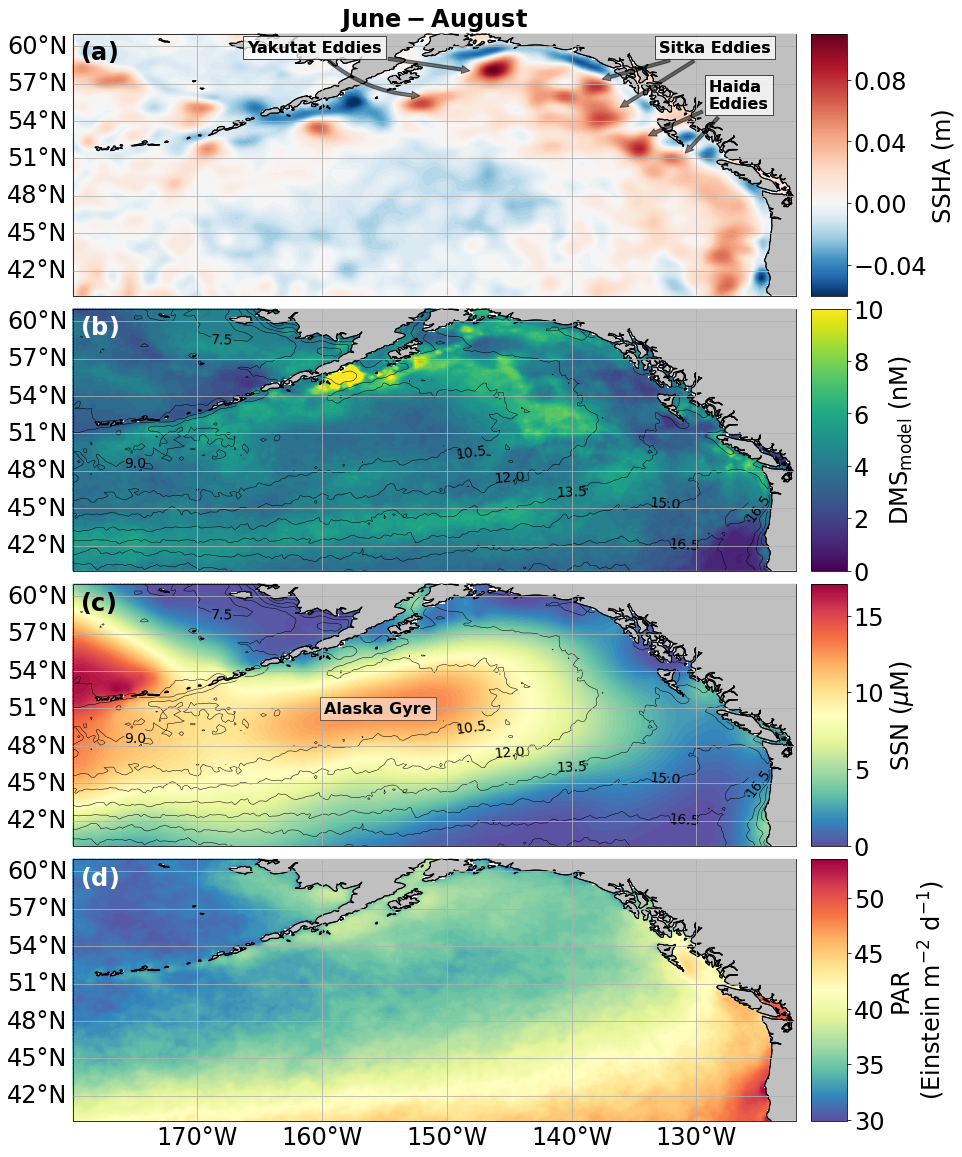

In [32]:
label_size = 16 # for eddies
sizing = 24 # for fonts
#------------------------------------------------------------------------------

zoomed_min_lat = 50
zoomed_max_lat = 62
zoomed_min_lon = -160
zoomed_max_lon = -127

fig = plt.figure(figsize=(44,20))
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}
dates = np.flip(np.unique(pd.to_datetime(arg=y_unstack.index.get_level_values('DateTime').values, format='%m').strftime('%B')))
date_ind = np.asarray([x[0] for x in X_full.index]).astype(float)
cmap='Spectral_r'
# quivercmap = plt.cm.winter
# res = 4 # 1= 0.25o, 2 = 0.5o, 4=1o, 8=2o
#------------------------------------------------------------------------------
#### SSHA
ax2 = fig.add_subplot(4,1,1, projection=ccrs.PlateCarree())
ax2.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
gl = ax2.gridlines(draw_labels=True, zorder=101)
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False
# if i != 0:
#     gl.left_labels = False
ax2.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
ax2.add_feature(cartopy.feature.COASTLINE, zorder=100, edgecolor='k')

norm = mpl.colors.TwoSlopeNorm(vmin=-0.06, vcenter=0, vmax=0.11)

h1 = ax2.pcolormesh(X_full.loc[:,['SSHA']].groupby(['latbins','lonbins']).mean().unstack('lonbins').columns.get_level_values('lonbins').values,
      X_full.loc[:,['SSHA']].groupby(['latbins','lonbins']).mean().unstack('lonbins').index.get_level_values('latbins').values,
      X_full.loc[:,['SSHA']].groupby(['latbins','lonbins']).mean().unstack('lonbins').values,
      shading='nearest',
      cmap=plt.cm.RdBu_r,
      norm=norm,
       vmin = -0.06, vmax = 0.11,
      transform=ccrs.PlateCarree())
h2 = ax2.contourf(X_full.loc[:,['SSHA']].groupby(['latbins','lonbins']).mean().unstack('lonbins').columns.get_level_values('lonbins').values,
      X_full.loc[:,['SSHA']].groupby(['latbins','lonbins']).mean().unstack('lonbins').index.get_level_values('latbins').values,
      X_full.loc[:,['SSHA']].groupby(['latbins','lonbins']).mean().unstack('lonbins').values,
      shading='nearest',
      cmap=plt.cm.RdBu_r,
      levels=100,
      vmin = -0.06, vmax = 0.11,
      norm=norm,
      transform=ccrs.PlateCarree())

# ax.set_title(r"$\bf{" + str(dates[i]) +"}$", fontsize=24)
divider = make_axes_locatable(ax2)
ax_cb2 = divider.new_horizontal(size="5%", pad=0.2, axes_class=plt.Axes)
fig.add_axes(ax_cb2)
cb2 = plt.colorbar(h1, cax=ax_cb2)
tick_locator = ticker.MaxNLocator(nbins=5)
cb2.locator = tick_locator
cb2.update_ticks()
cb2.ax.tick_params(labelsize=sizing)
cb2.set_label(r'SSHA (m)', fontsize=sizing)

# ax2.text(0.1, 0.9, 'SSHA', transform=ax2.transAxes, fontsize=19, fontweight='bold',
#             va='center', ha='center', bbox=dict(facecolor='white', alpha=1), zorder=500)
ax2.annotate('Haida \nEddies', xy=(-134,52.75), xytext=(-129,55),arrowprops=dict(facecolor='k',
                            arrowstyle="simple",
                            # connectionstyle="arc3,rad=-0.2",
                            alpha=0.5),
              bbox=dict(facecolor='white', alpha=0.5),
              fontsize=label_size, fontweight='bold',xycoords=ccrs.PlateCarree()._as_mpl_transform(ax2), zorder=1000)
ax2.annotate('Haida \nEddies', xy=(-131,51.3), xytext=(-129,55),arrowprops=dict(facecolor='k',
                            arrowstyle="simple",
                            # connectionstyle="arc3,rad=-0.2",
                            alpha=0.5),
              bbox=dict(facecolor='white', alpha=0.5),
              fontsize=label_size, fontweight='bold',xycoords=ccrs.PlateCarree()._as_mpl_transform(ax2), zorder=1000)
ax2.annotate('Sitka Eddies', xy=(-137.7,57.3), xytext=(-133,59.5),arrowprops=dict(facecolor='k',
                            arrowstyle="simple",
                            # connectionstyle="arc3,rad=-0.2",
                            alpha=0.5),
              bbox=dict(facecolor='white', alpha=0.5),
              fontsize=label_size, fontweight='bold',xycoords=ccrs.PlateCarree()._as_mpl_transform(ax2), zorder=1000)
ax2.annotate('Sitka Eddies', xy=(-136.25,55), xytext=(-133,59.5),arrowprops=dict(facecolor='k',
                            arrowstyle="simple",
                            # connectionstyle="arc3,rad=-0.2",
                            alpha=0.5),
              bbox=dict(facecolor='white', alpha=0.5),
              fontsize=label_size, fontweight='bold',xycoords=ccrs.PlateCarree()._as_mpl_transform(ax2), zorder=1000)
ax2.annotate('Yakutat Eddies', xy=(-148,58), xytext=(-166,59.5),
             arrowprops=dict(facecolor='k',
                            arrowstyle="simple",
                            # connectionstyle="arc3,rad=0.5",
                            alpha=0.5),
              bbox=dict(facecolor='white', alpha=0.5),
              fontsize=label_size,fontweight='bold', xycoords=ccrs.PlateCarree()._as_mpl_transform(ax2), zorder=1000)
ax2.annotate('Yakutat Eddies', xy=(-152,56), xytext=(-166,59.5),
             arrowprops=dict(facecolor='k',
                            arrowstyle="simple",
                            connectionstyle="arc3,rad=0.2",
                            alpha=0.5),
              bbox=dict(facecolor='white', alpha=0.5),
              fontsize=label_size, fontweight='bold', xycoords=ccrs.PlateCarree()._as_mpl_transform(ax2), zorder=1000)
ax2.text(0.01,0.9,'$\mathbf{(a)}$',fontsize='24', color='k', transform=ax2.transAxes, zorder=1000)
ax2.set_title(r"$\mathbf{June-August}$", fontsize=sizing)
#------------------------------------------------------------------------------
#### DMS
ax = fig.add_subplot(4,1,2, projection=ccrs.PlateCarree())
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, zorder=101)
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False
# if i != 0:
#     gl.left_labels = False
ax.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
ax.add_feature(cartopy.feature.COASTLINE, zorder=100, edgecolor='k')

models_combined = pd.DataFrame(pd.concat([np.sinh(y_pred_stack),np.sinh(ANN_y_pred)],axis=1).mean(axis=1).values, index=X_full.index).groupby(['latbins','lonbins']).mean()

# levels = np.linspace(0,8,100)
h1 = ax.pcolormesh(models_combined.unstack('lonbins').columns.get_level_values('lonbins').values,
      models_combined.unstack('lonbins').index.get_level_values('latbins').values,
      models_combined.unstack('lonbins').values,
      shading='nearest',
      cmap=plt.cm.viridis,
      # levels=100,
       vmin = 0, vmax = 10,
      # norm=mpl.colors.LogNorm(),
      transform=ccrs.PlateCarree())
h2 = ax.contourf(models_combined.unstack('lonbins').columns.get_level_values('lonbins').values,
      models_combined.unstack('lonbins').index.get_level_values('latbins').values,
      models_combined.unstack('lonbins').values,
      shading='nearest',
      cmap=plt.cm.viridis,
      levels=100,
      vmin = 0, vmax = 10,
      transform=ccrs.PlateCarree())

# Add SST contours
T_contour = ax.contour(X_full.loc[:,['SST']].groupby(['latbins','lonbins']).mean().unstack('lonbins').columns.get_level_values('lonbins').values,
                        X_full.loc[:,['SST']].groupby(['latbins','lonbins']).mean().unstack('lonbins').index.get_level_values('latbins').values,
                        X_full.loc[:,['SST']].groupby(['latbins','lonbins']).mean().unstack('lonbins').values,
                        levels=10,
                        colors='k',
                        linewidths=0.5,
                        transform=ccrs.PlateCarree())
manual_locs = [(-148,48.5), (-145,48), (-140,46.5), (-132.5,45), (-125,45), (-131,42), (-175,48), (-168,58),]
ax.clabel(T_contour,
          inline=True, inline_spacing=25,
          fmt='%1.1f', rightside_up=True, fontsize=14,
          manual=manual_locs)




# h1.set_clim([0,8])
# ax.contour(models_combined.unstack('lonbins').columns.get_level_values('lonbins').values,
#       models_combined.unstack('lonbins').index.get_level_values('latbins').values,
#       models_combined.unstack('lonbins').values,
#       levels=5,
#       colors='k',
#       transform=ccrs.PlateCarree())
# ax.set_title(r"$\mathbf{June-August}$", fontsize=sizing)
divider = make_axes_locatable(ax)
ax_cb2 = divider.new_horizontal(size="5%", pad=0.2, axes_class=plt.Axes)
fig.add_axes(ax_cb2)
cb2 = plt.colorbar(h1, cax=ax_cb2)
cb2.ax.tick_params(labelsize=sizing)
cb2.set_label(r'DMS$_{\rmmodel}$ (nM)', fontsize=sizing)
# ax.text(0.1, 0.9, 'DMS', transform=ax.transAxes, fontsize=19, fontweight='bold',
#             va='center', ha='center', bbox=dict(facecolor='white', alpha=1), zorder=500)
ax.text(0.01,0.9,'$\mathbf{(b)}$',fontsize='24', color='w', transform=ax.transAxes, zorder=1000)
#------------------------------------------------------------------------------
#### SSN
ax3 = fig.add_subplot(4,1,3, projection=ccrs.PlateCarree())
ax3.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
gl = ax3.gridlines(draw_labels=True, zorder=101)
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False
# if i != 0:
#     gl.left_labels = False
ax3.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
ax3.add_feature(cartopy.feature.COASTLINE, zorder=100, edgecolor='k')

h1 = ax3.pcolormesh(X_full.loc[:,['SSN']].groupby(['latbins','lonbins']).mean().unstack('lonbins').columns.get_level_values('lonbins').values,
      X_full.loc[:,['SSN']].groupby(['latbins','lonbins']).mean().unstack('lonbins').index.get_level_values('latbins').values,
      X_full.loc[:,['SSN']].groupby(['latbins','lonbins']).mean().unstack('lonbins').values,
      shading='nearest',
      cmap=cmap,
      # levels=100,
       # vmin = -0.06, vmax = 0.1,
      transform=ccrs.PlateCarree())
h2 = ax3.contourf(X_full.loc[:,['SSN']].groupby(['latbins','lonbins']).mean().unstack('lonbins').columns.get_level_values('lonbins').values,
      X_full.loc[:,['SSN']].groupby(['latbins','lonbins']).mean().unstack('lonbins').index.get_level_values('latbins').values,
      X_full.loc[:,['SSN']].groupby(['latbins','lonbins']).mean().unstack('lonbins').values,
      shading='nearest',
      cmap=cmap,
      levels=100,
        # vmin = -0.06, vmax = 0.1,
      transform=ccrs.PlateCarree())
# ax3.contour(X_full.loc[:,['SSHA']].groupby(['latbins','lonbins']).mean().unstack('lonbins').columns.get_level_values('lonbins').values,
#       X_full.loc[:,['SSHA']].groupby(['latbins','lonbins']).mean().unstack('lonbins').index.get_level_values('latbins').values,
#       X_full.loc[:,['SSHA']].groupby(['latbins','lonbins']).mean().unstack('lonbins').values,
#       # levels=100,
#       colors='k',
#       transform=ccrs.PlateCarree())
# ax.set_title(r"$\bf{" + str(dates[i]) +"}$", fontsize=24)
divider = make_axes_locatable(ax3)
ax_cb2 = divider.new_horizontal(size="5%", pad=0.2, axes_class=plt.Axes)
fig.add_axes(ax_cb2)
cb2 = plt.colorbar(h1, cax=ax_cb2)
cb2.ax.tick_params(labelsize=sizing)
cb2.set_label(r'SSN ($\mu$M)', fontsize=sizing)
ax3.text(0.01,0.9,'$\mathbf{(c)}$',fontsize='24', color='k', transform=ax3.transAxes, zorder=1000)
ax3.text(-155.5,51,'Alaska Gyre', fontsize=label_size, fontweight='bold',
            va='center', ha='center', bbox=dict(facecolor='white', alpha=0.5), zorder=500)
# Add SST contours
T_contour = ax3.contour(X_full.loc[:,['SST']].groupby(['latbins','lonbins']).mean().unstack('lonbins').columns.get_level_values('lonbins').values,
                        X_full.loc[:,['SST']].groupby(['latbins','lonbins']).mean().unstack('lonbins').index.get_level_values('latbins').values,
                        X_full.loc[:,['SST']].groupby(['latbins','lonbins']).mean().unstack('lonbins').values,
                        levels=10,
                        colors='k',
                        linewidths=0.5,
                        transform=ccrs.PlateCarree())
manual_locs = [(-148,48.5), (-145,48), (-140,46.5), (-132.5,45), (-125,45), (-131,42), (-175,48), (-168,58),]
ax3.clabel(T_contour,
          inline=True, inline_spacing=25,
          fmt='%1.1f', rightside_up=True, fontsize=14,
          manual=manual_locs)

#------------------------------------------------------------------------------
#### PAR
var_ = 'PAR'
# var_ = 'a$_{cdm}$(443)'

ax4 = fig.add_subplot(4,1,4, projection=ccrs.PlateCarree())
ax4.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
gl = ax4.gridlines(draw_labels=True, zorder=101)
gl.top_labels = False
gl.right_labels = False
# if i != 0:
#     gl.left_labels = False
ax4.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k', facecolor='silver')
ax4.add_feature(cartopy.feature.COASTLINE, zorder=100, edgecolor='k')
h1 = ax4.pcolormesh(X_full.loc[:,[var_]].groupby(['latbins','lonbins']).mean().unstack('lonbins').columns.get_level_values('lonbins').values,
      X_full.loc[:,[var_]].groupby(['latbins','lonbins']).mean().unstack('lonbins').index.get_level_values('latbins').values,
      X_full.loc[:,[var_]].groupby(['latbins','lonbins']).mean().unstack('lonbins').values,
      shading='nearest',
      cmap=cmap,
      # levels=100,
      # vmin = 10, vmax = 15,
       # norm=mpl.colors.LogNorm(),
      transform=ccrs.PlateCarree())
h3 = ax4.contourf(X_full.loc[:,[var_]].groupby(['latbins','lonbins']).mean().unstack('lonbins').columns.get_level_values('lonbins').values,
      X_full.loc[:,[var_]].groupby(['latbins','lonbins']).mean().unstack('lonbins').index.get_level_values('latbins').values,
      X_full.loc[:,[var_]].groupby(['latbins','lonbins']).mean().unstack('lonbins').values,
      shading='nearest',
      cmap=cmap,
      levels=100,
      # vmin = 10, vmax = 15,
      transform=ccrs.PlateCarree())

# # Add SST contours
# T_contour = ax4.contour(X_full.loc[:,['SST']].groupby(['latbins','lonbins']).mean().unstack('lonbins').columns.get_level_values('lonbins').values,
#                         X_full.loc[:,['SST']].groupby(['latbins','lonbins']).mean().unstack('lonbins').index.get_level_values('latbins').values,
#                         X_full.loc[:,['SST']].groupby(['latbins','lonbins']).mean().unstack('lonbins').values,
#                         levels=10,
#                         colors='k',
#                         linewidths=0.5,
#                         transform=ccrs.PlateCarree())
# manual_locs = [(-148,48.5), (-145,48), (-140,46.5), (-132.5,45), (-125,45), (-131,42), (-175,48), (-168,58),]
# ax4.clabel(T_contour,
#           inline=True, inline_spacing=25,
#           fmt='%1.1f', rightside_up=True, fontsize=14,
#           manual=manual_locs)


divider = make_axes_locatable(ax4)
ax_cb2 = divider.new_horizontal(size="5%", pad=0.2, axes_class=plt.Axes)
fig.add_axes(ax_cb2)
cb2 = plt.colorbar(h1, cax=ax_cb2)
cb2.ax.tick_params(labelsize=sizing)
cb2.set_label(r'PAR'+'\n'+r'($\rmEinstein\ m^{-2}\ d^{-1}$)', fontsize=sizing)

# ax4.text(0.1, 0.9, 'SST', transform=ax4.transAxes, fontsize=19, fontweight='bold',
#             va='center', ha='center', bbox=dict(facecolor='white', alpha=1), zorder=500)
# ax4.text(-155.5,51.5,'Alaska Gyre', fontsize=18, fontweight='bold',
#             va='center', ha='center', bbox=dict(facecolor='white', alpha=1), zorder=500)
ax4.text(0.01,0.9,'$\mathbf{(d)}$',fontsize='24', color='w', transform=ax4.transAxes, zorder=1000)
#------------------------------------------------------------------------------
fig.subplots_adjust(hspace=0.05)

fig.savefig(save_to_path+str('Regional_Drivers.png'), dpi=300, bbox_inches='tight')
fig.savefig(save_to_path+str('Fig09.pdf'), dpi=300, bbox_inches='tight')

## Visualize an RFR tree 

In [33]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=800)
tree.plot_tree(RFR_model.estimators_[0],
                feature_names = X_full.columns,
                max_depth=25,
                filled = True);
fig.savefig(save_to_path+str('Individual_Tree.png'), dpi=500, transparent=True, bbox_inches='tight')

## PCA biplot

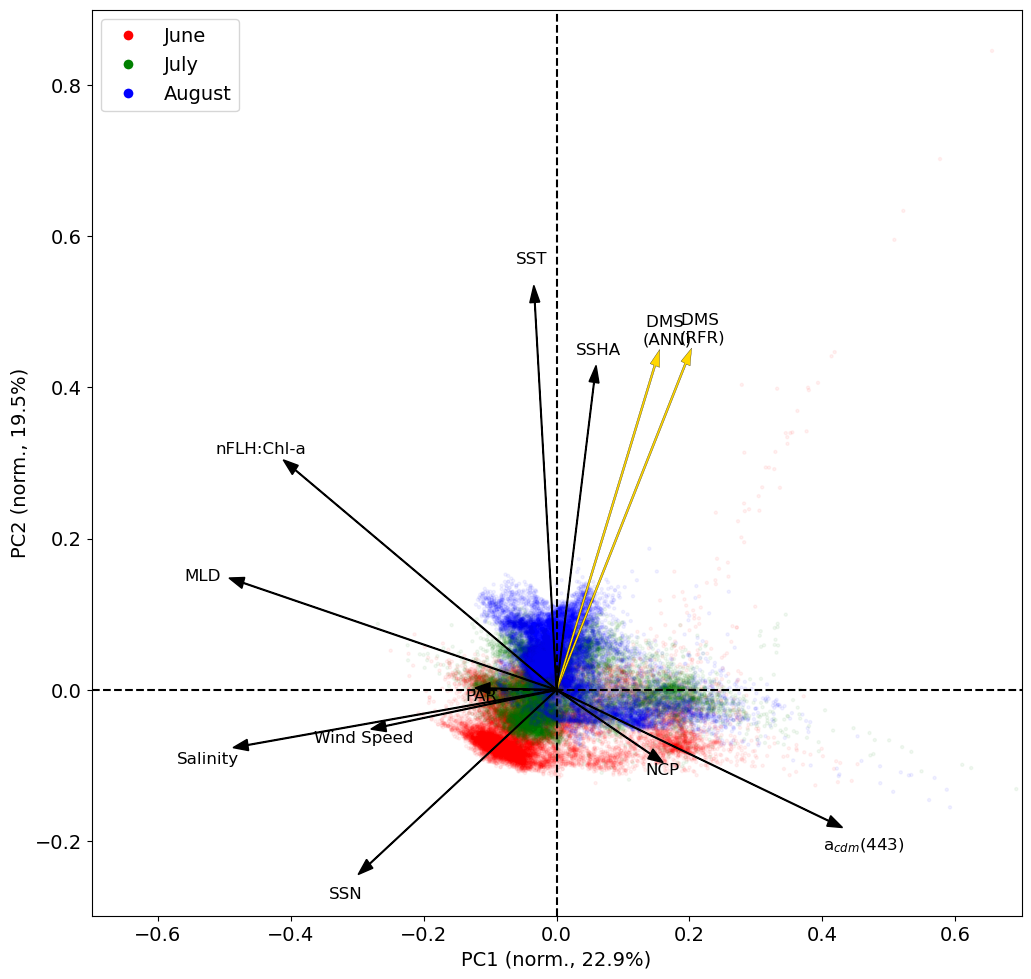

In [34]:
#### Create combined dataset
PCA_combine = pd.concat([np.sinh(y_pred_stack),np.sinh(ANN_y_pred),X_full],axis=1).rename({'DMS':'DMS \n(RFR)',0:'DMS \n(ANN)'}, axis=1)
PCA_scaler = StandardScaler()
PCA_scaler.fit(PCA_combine)
data_norm = pd.DataFrame(PCA_scaler.transform(PCA_combine), index=PCA_combine.index, columns=PCA_combine.columns)

#### Apply PCA
n_modes = np.shape(data_norm)[1]
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(data_norm)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_
EDC = (2/data_norm.shape[1])**0.5 # used for drawing equilibrium circle on biplot


#### PCA biplot
# biplot function adapted from here: https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot
from matplotlib.lines import Line2D
def biplot(PCA_input, PCs, eigvecs, fracVar, EDC, labels=None):
    '''
    Author: Serafeim Loukas, serafeim.loukas@epfl.ch
    Inputs:
       PCs: the projected data
       eigvecs: the eigenvectors (PCs)
       y: the class labels
   '''
    dates = np.asarray([x[0] for x in PCA_input.index])
    color_list = [{6:"r",7:"g",8:"b"}[x] for x in dates]
    custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=8, lw=4),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=8, lw=4),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=8, lw=4)]
    xs = PCs[:,0] # projection on PC1
    ys = PCs[:,1] # projection on PC2
    n = eigvecs.shape[0] # number of variables
    fig = plt.figure(figsize=(12,12), dpi=100)
    ax = fig.add_subplot(111)
    # colors = ['g','r','y']
    # markers=['o','^','x']
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    # Plot PCs
    ax.scatter(xs*scalex, ys*scaley, s=5, c=color_list, alpha=0.05)
    # Plot axes origin lines
    ax.axhline(0, color='k', ls='--')
    ax.axvline(0, color='k', ls='--')
    # Draw Equilibrium Descripter Circle (EDC)
    # plt.gca().add_patch(mpl.patches.Circle((0,0), EDC, facecolor='None', edgecolor='k', linestyle='-', lw=0.5))
    # Plot vectors
    for i in range(n):
        if i==0 or i==1:
            ax.arrow(0, 0, eigvecs[i,0], eigvecs[i,1], color='k', fc='gold', ls='-', width=0.003, lw=0.2, head_width=0.015, alpha=1)
        else:
            ax.arrow(0, 0, eigvecs[i,0], eigvecs[i,1], color='k', head_width=0.015, alpha=1)
        if labels is None:
            ax.text(eigvecs[i,0]* 1.15, eigvecs[i,1] * 1.15, "Var"+str(i+1), color='k', ha='center', va='center', fontsize=12)
        else:
            ax.text(eigvecs[i,0]*1.13, eigvecs[i,1]*1.13-0.01, labels[i], color='k', ha='center', va='center', fontsize=12)
    ax.set_xlabel("PC1 (norm.,"+" {0:.1%}".format(fracVar[0])+")", size=14)
    ax.set_ylabel("PC2 (norm.,"+" {0:.1%}".format(fracVar[1])+")", size=14)
    ax.legend(custom_lines, ['June', 'July', 'August'], fontsize=14)
    ax.set_xlim([-0.7,0.7])
    # limx= int(xs.max()) + 1
    # limy= int(ys.max()) + 1
    # plt.xlim([-1,1])
    # plt.ylim([-1,1])
    # plt.grid()
    ax.tick_params(axis='both', which='both', labelsize=14)
    return fig, ax
    
# Now plot
fig, ax = biplot(PCA_combine, PCs[:,:2],eigvecs.T[:,:2], fracVar, EDC, labels=list(data_norm.columns))
# ax.gca().tick_params(axis='x', which='minor')

fig.savefig(save_to_path+str('PCA.png'), dpi=300, transparent=True, bbox_inches='tight')
fig.savefig(save_to_path+str('Fig06.pdf'), dpi=300, bbox_inches='tight')

## Spearman rank correlations

                     rho        R2        p-value
Variable                                         
SST             0.360787  0.130167   0.000000e+00
PAR            -0.210570  0.044340   0.000000e+00
SSHA            0.352349  0.124150   0.000000e+00
Wind Speed     -0.146204  0.021376  3.342665e-235
nFLH:Chl-a      0.146409  0.021436  7.321685e-236
a$_{cdm}$(443) -0.042579  0.001813   2.311570e-21
MLD            -0.086989  0.007567   5.646700e-84
Salinity       -0.256872  0.065983   0.000000e+00
SSN            -0.147385  0.021722  5.048969e-239
NCP             0.079796  0.006367   6.464009e-71
                     rho        R2        p-value
Variable                                         
SST             0.329421  0.108518   0.000000e+00
PAR            -0.286167  0.081892   0.000000e+00
SSHA            0.410371  0.168404   0.000000e+00
Wind Speed     -0.115207  0.013273  3.128222e-146
nFLH:Chl-a      0.145209  0.021086  5.268853e-232
a$_{cdm}$(443) -0.058959  0.003476   1.791623e-39


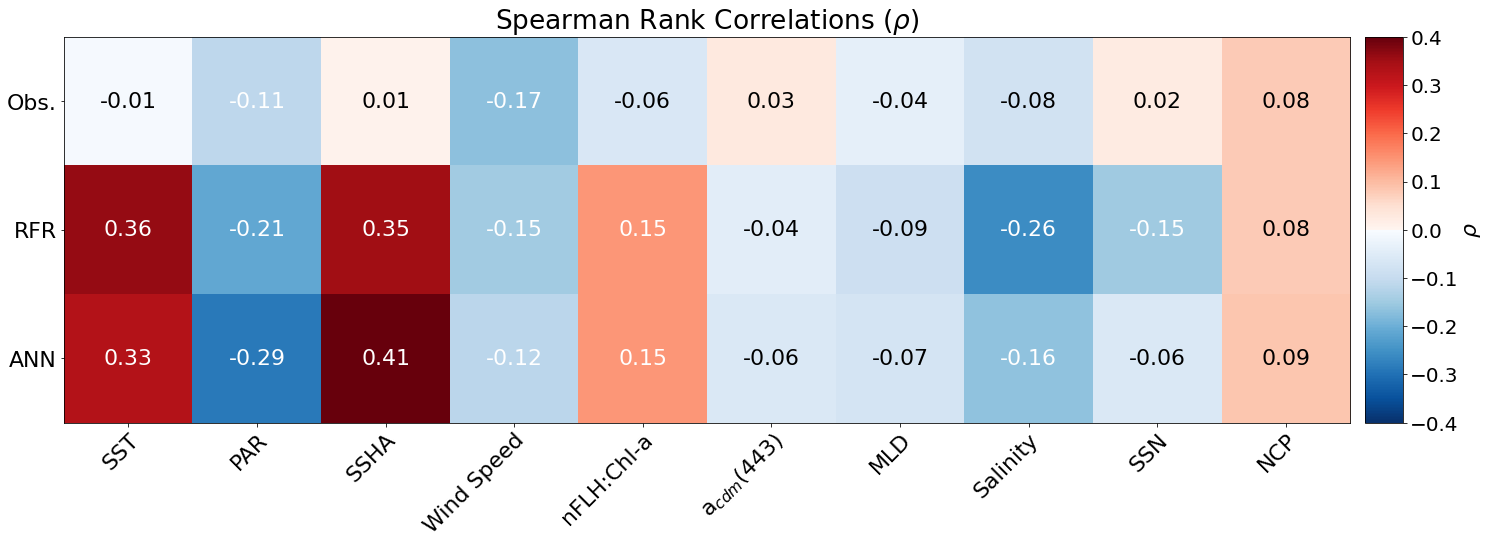

In [35]:
# Use spearman rank to assess non-linear relationships
#-----------------------------------------------------------------------------
#### RFR correlations
rhos = []
pvals = []
names = X_full.columns.values
for i in range(len(X_full.columns.values)):
    rho, pval = spearmanr(X_full.iloc[:,i].values,np.sinh(y_pred_stack.values))
    rhos.append(rho)
    pvals.append(pval)
RFR_correlations = pd.concat([pd.Series(names),pd.Series(rhos),pd.Series(np.array(rhos)**2),pd.Series(pvals)], axis=1)
RFR_correlations.columns = ['Variable','rho','R2','p-value']
RFR_correlations.set_index('Variable', inplace=True)
# RFR_correlations = RFR_correlations.reindex(RFR_correlations.rho.abs().sort_values(ascending=False).index)
#-----------------------------------------------------------------------------
#### ANN correlations
rhos = []
pvals = []
names = X_full.columns.values
for i in range(len(X_full.columns.values)):
    rho, pval = spearmanr(X_full.iloc[:,i].values,np.sinh(ANN_y_pred.values))
    rhos.append(rho)
    pvals.append(pval)
ANN_correlations = pd.concat([pd.Series(names),pd.Series(rhos),pd.Series(np.array(rhos)**2),pd.Series(pvals)], axis=1)
ANN_correlations.columns = ['Variable','rho','R2','p-value']
ANN_correlations.set_index('Variable', inplace=True)
# ANN_correlations = ANN_correlations.reindex(ANN_correlations.rho.abs().sort_values(ascending=False).index)
#------------------------------------------------------------------------------
#### Raw Data
rhos = []
pvals = []
names = X_full.columns.values
for i in range(len(X.columns.values)):
    rho, pval = spearmanr(X.iloc[:,i].values,np.sinh(y.values))
    rhos.append(rho)
    pvals.append(pval)
correlations = pd.concat([pd.Series(names),pd.Series(rhos),pd.Series(np.array(rhos)**2),pd.Series(pvals)], axis=1)
correlations.columns = ['Variable','rho','R2','p-value']
correlations.set_index('Variable', inplace=True)
# correlations = correlations.reindex(correlations.rho.abs().sort_values(ascending=False).index)
#------------------------------------------------------------------------------
print(RFR_correlations)
print(ANN_correlations)
print(correlations)
#------------------------------------------------------------------------------
corr_mat = pd.concat([correlations['rho'],RFR_correlations['rho'],ANN_correlations['rho']],axis=1)
corr_mat.columns=['Obs.','RFR','ANN']
corr_mat=corr_mat.T

#### Plot heatmap
fig = plt.figure(figsize=(24,24))
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}
mpl.rc('font', **font)
ax = fig.add_subplot(111)

# Set up diverging colormaps...
colors1 = plt.cm.Blues_r(np.linspace(0, 1, 128))
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
# ...combine them and build a new colormap
colors = np.vstack((colors1, colors2))
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors)

# normalize cmap to diverge at 0
norm = mpl.colors.TwoSlopeNorm(vmin=-0.4, vcenter=0, vmax=0.4)

# plot data
im = ax.imshow(corr_mat, cmap=cmap, norm=norm)

# We want to show all ticks...
ax.set_xticks(np.arange(len(corr_mat.columns.values)))
ax.set_yticks(np.arange(len(corr_mat.index.values)))
# ... and label them with the respective list entries
ax.set_xticklabels(corr_mat.columns.values)
ax.set_yticklabels(corr_mat.index.values)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(len(corr_mat.index.values)):
    for j in range(len(corr_mat.columns.values)):
        if corr_mat.iloc[i, j]<0.1 and corr_mat.iloc[i, j]>-0.1:
            text = ax.text(j, i, round(corr_mat.iloc[i, j], ndigits=2),
                           ha="center", va="center", color="k")
        else:
            text = ax.text(j, i, round(corr_mat.iloc[i, j], ndigits=2),
                       ha="center", va="center", color="w")
ax.set_title(r'Spearman Rank Correlations ($\rho$)')
divider = make_axes_locatable(ax)
ax_cb2 = divider.new_horizontal(size="3%", pad=0.2, axes_class=plt.Axes)
fig.add_axes(ax_cb2)
cb2 = plt.colorbar(im, cax=ax_cb2)
cb2.ax.tick_params(labelsize=20)
cb2.set_label(r'$\rho$')

fig.savefig(save_to_path+str('heatmap.png'), dpi=300, transparent=True, bbox_inches='tight')
fig.savefig(save_to_path+str('Fig07.pdf'), dpi=300, bbox_inches='tight')

## Script Runtime

In [36]:
analysis_end = timeit.default_timer()
analysis_runtime = analysis_end-analysis_start
print('Analysis Runtime:')
print(str(round(analysis_runtime,5)),'secs')
print(str(round((analysis_runtime)/60,5)),'mins')
print(str(round((analysis_runtime)/3600,5)),'hrs')

Analysis Runtime:
22090.58765 secs
368.17646 mins
6.13627 hrs
